# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [186]:
# pip install scikit-learn pandas numpy matplotlib seaborn joblib datetime scipy yellowbrick xlrd tables xgboost imblearn pandas_profiling
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from yellowbrick.cluster import SilhouetteVisualizer

from time import time
import datetime
import joblib 

from featureengineering import Documentation, FeatureEngineer, PreProcessor
from common_functions import numpy_array_to_df, representative_sample, is_numeric, load_dataframe, save_dataframe, load_model, save_model, \
    fitted_k_mean_models, kmeans_scores, silhouette_scores


# magic word for producing visualizations in notebook
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
root_path='.'
out_dirname = 'tmp_results'

In [3]:
# load in the data

azdias = pd.read_csv(f'{root_path}/../data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv(f'{root_path}/../data/Udacity_CUSTOMERS_052018.csv', sep=';')
mailout_train = pd.read_csv(f'{root_path}/../data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv(f'{root_path}/../data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\thorssc\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           NaN         NaN           NaN                         NaN   
1           0.0         0.0           2.0                        12.0   
2           0.0         0.0           1.0                         7.0   
3           0.0         0.0           0.0                         2.0   
4           0.0         0.0           4.0                         3.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        NaN     NaN       NaN            NaN             NaN             NaN   
1        0.0     3.0       6.0             8A               8              51   
2        0.0     3.0       2.0             4C               4              24   
3        0.0     2.0       4.0             2A               2              12   
4        0.0     4.0       2.0             6B               6              43   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            2.0                5.0        1.0        1.0        5.0   
1            5.0                1.0        5.0        5.0        2.0   
2            3.0                2.0        4.0        4.0        1.0   
3            2.0                3.0        2.0        2.0        4.0   
4            5.0                3.0        3.0        3.0        3.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0        5.0        5.0        5.0                  0                  0   
1        3.0        1.0        1.0                  0                  0   
2        3.0        2.0        2.0                  0                  0   
3        4.0        5.0        3.0                  0                  0   
4        4.0        3.0        3.0                  3                  5   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0                10                  0                 0                 0   
1                10                  0                 0                 0   
2                10                  0                 0                 0   
3                10                  0                 0                 0   
4                 5                  1                 2                 0   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                        10                       10   
1                        10                       10   
2                        10                       10   
3                        10                       10   
4                        10                        5   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         NaN                0                   0   
1                         NaN                0                   0   
2                         0.0                0                   0   
3                         0.0                0                   0   
4                        10.0                6                   6   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                    0   

## Instantiate PreProcessor and Prepare the data
### Create an instance of Documentation
* First create an instance of *Documentation*
* The *Documentation* class wraps the **'DIAS Attributes - Values 2017.xlsx'** in a dictionary and applies a few modifications on the data. The modifications are:
    * Renaming of columns to match with the columns of the DataFrames
    * Recode (split) 'CAMEO_INTL_2015' -> 'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_FAMILY_AGE'
    * Recode 'LP_FAMILIE_GROB'
    * Recode 'LP_STATUS_GROB'
    * Recode 'OST_WEST_KZ'
    * Recode 'D19_KONSUMTYP'
    

In [5]:
documentation_df = pd.read_excel(f'{root_path}/../data/DIAS Attributes - Values 2017.xlsx', header=None)\
                .dropna(axis=0, how='all')\
                .dropna(axis=1, how='all')\
                .iloc[1:,:]

documentation = Documentation(documentation_df)
del documentation_df

### Create an instance of FeatureEngineer
* Now that we have our *'documentation'* variable we can create an instance of the *FeatureEngineer* class
* The *FeatureEngineer* is our worker-class. It provides methods for preprocessing the data
* To create the instance we just pass our *Documentation* to the constructor

In [6]:
%%time
feature_engineer = FeatureEngineer(documentation)

Wall time: 0 ns


### Create an instance the PreProcessor class
* The *PreProcessor* class orchestrates the pre-processing steps with the 4 datasets (azdias, customers, mailout_train, mailout_test)
* Preprocessing is done in the *process()*-method 
* 5 steps
    * Step 1: Clean (drop unneeded cols, set invalid values to np.nan, ensure equal spacing of codes, remove unknown values)
    * Step 2: Remove outliers, cols with too low stddev
    * Step 3: Remove missing values and recode composite features
    * Step 4: Impute (first GEBURTSJAHR then the other features)
    * Step 5: Scale (apply StandardScaler for PCA)
* The inermediate results are persisted to *hdf* files in each step and can be reloaded

In [7]:
%%time
pre_processor = PreProcessor(
    feature_engineer,
    azdias, customers, 
    mailout_train, mailout_test,
    root_path=root_path, out_dir=out_dirname
)
pre_processor.process()

Step 1: Clean
azdias, customers
mailout_train, mailout_test


C:\Users\thorssc\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE',
       'OST_WEST_KZ'],
      dtype='object')]

  encoding=encoding,


Step 2: Handle Outliers and cols with low stddev
azdias, customers
mailout_train, mailout_test
azdias, customers
mailout_train, mailout_test


C:\Users\thorssc\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE',
       'OST_WEST_KZ'],
      dtype='object')]

  encoding=encoding,


Step 3: Remove missing values and recode composite features
azdias, customers
mailout_train, mailout_test
Step 4: Impute
_impute_geburtsjahr: azdias, customers
[IterativeImputer] Completing matrix with shape (891221, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 48.15
[IterativeImputer] Ending imputation round 2/10, elapsed time 96.28
[IterativeImputer] Ending imputation round 3/10, elapsed time 145.35
[IterativeImputer] Ending imputation round 4/10, elapsed time 194.16
[IterativeImputer] Ending imputation round 5/10, elapsed time 243.76
[IterativeImputer] Ending imputation round 6/10, elapsed time 294.48
[IterativeImputer] Ending imputation round 7/10, elapsed time 343.58
[IterativeImputer] Ending imputation round 8/10, elapsed time 391.68
[IterativeImputer] Ending imputation round 9/10, elapsed time 440.28
[IterativeImputer] Ending imputation round 10/10, elapsed time 489.11
[IterativeImputer] Completing matrix with shape (191652, 5)
[IterativeImputer] Ending imput

### Take a look at the AZDIAS before and after preprocessing

In [8]:
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           NaN         NaN           NaN                         NaN   
1           0.0         0.0           2.0                        12.0   
2           0.0         0.0           1.0                         7.0   
3           0.0         0.0           0.0                         2.0   
4           0.0         0.0           4.0                         3.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        NaN     NaN       NaN            NaN             NaN             NaN   
1        0.0     3.0       6.0             8A               8              51   
2        0.0     3.0       2.0             4C               4              24   
3        0.0     2.0       4.0             2A               2              12   
4        0.0     4.0       2.0             6B               6              43   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            2.0                5.0        1.0        1.0        5.0   
1            5.0                1.0        5.0        5.0        2.0   
2            3.0                2.0        4.0        4.0        1.0   
3            2.0                3.0        2.0        2.0        4.0   
4            5.0                3.0        3.0        3.0        3.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0        5.0        5.0        5.0                  0                  0   
1        3.0        1.0        1.0                  0                  0   
2        3.0        2.0        2.0                  0                  0   
3        4.0        5.0        3.0                  0                  0   
4        4.0        3.0        3.0                  3                  5   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0                10                  0                 0                 0   
1                10                  0                 0                 0   
2                10                  0                 0                 0   
3                10                  0                 0                 0   
4                 5                  1                 2                 0   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                        10                       10   
1                        10                       10   
2                        10                       10   
3                        10                       10   
4                        10                        5   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         NaN                0                   0   
1                         NaN                0                   0   
2                         0.0                0                   0   
3                         0.0                0                   0   
4                        10.0                6                   6   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                    0   

In [9]:
scaled_azdias, scaled_customers = pre_processor.load_step_5_scaled_dfs()[0:2]

In [10]:
scaled_azdias.head()

AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_PERSONEN  \
LNR                                                     
910215    0.150901             0.029646     -0.593390   
910220    1.296950             0.616636      0.295412   
910225    1.296950             0.469888     -0.593390   
910226   -0.995149            -0.850840     -1.482193   
910241   -0.995149            -0.557344      2.073018   

        ANZ_STATISTISCHE_HAUSHALTE    ARBEIT  BALLRAUM  CAMEO_DEUG_2015  \
LNR                                                                       
910215                   -0.045381 -0.158280 -0.066651        -0.235255   
910220                    0.875552 -0.158280  0.901186         1.038880   
910225                    0.108108 -0.158280 -1.034488        -0.659967   
910226                   -0.659335 -1.213155 -0.066651        -1.509390   
910241                   -0.505847  0.896595 -1.034488         0.189456   

        CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
LNR                                                                         
910215      -1.026408           1.117239  -1.734308  -1.567861   1.182363   
910220       0.859140          -1.567031   1.196111   1.290419  -0.969660   
910225      -0.397892          -0.895963   0.463506   0.575849  -1.687001   
910226      -1.026408          -0.224896  -1.001703  -0.853291   0.465022   
910241       0.859140          -0.224896  -0.269098  -0.138721  -0.252319   

        CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
LNR                                                                             
910215   1.213825   1.189919   1.156188          -0.228259          -0.294032   
910220  -0.245903  -1.715538  -1.859887          -0.228259          -0.294032   
910225  -0.245903  -0.989174  -1.105868          -0.228259          -0.294032   
910226   0.483961   1.189919  -0.351849          -0.228259          -0.294032   
910241   0.483961  -0.262809  -0.351849           5.369283           6.391335   

        D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  \
LNR                                                             
910215          0.422060          -0.443741         -0.345901   
910220          0.422060          -0.443741         -0.345901   
910225          0.422060          -0.443741         -0.345901   
910226          0.422060          -0.443741         -0.345901   
910241         -2.458583           0.053317          0.870819   

        D19_BANKEN_LOKAL  D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
LNR                                                                           
910215         -0.132111                  0.120874                 0.362409   
910220         -0.132111                  0.120874                 0.362409   
910225         -0.132111                  0.120874                 0.362409   
910226         -0.132111                  0.120874                 0.362409   
910241         -0.132111                  0.120874                -2.868040   

        D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
LNR                                                                       
910215                   -0.230507        -0.281739           -0.303388   
910220                   -0.230507        -0.281739           -0.303388   
910225                   -0.230507        -0.281739           -0.303388   
910226                   -0.230507        -0.281739           -0.303388   
910241                    4.363388         3.689717            3.587285   

        D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
LNR                                                                   
910215            -0.505301    -0.296161     -0.205967    -0.622234   
910220            -0.505301    -0.296161     -0.205967    -0.622234   
910225            -0.505301     3.363851     -0.205967    -0.622234   
910226            -0.505301    -0.296161     -0.205967     1.732624   
910241      

## PCA

In [11]:
%%time
pca = PCA(scaled_azdias.shape[1])

pca_azdias = pca.fit(scaled_azdias)

Wall time: 8.12 s


In [12]:
%%time
pca = PCA(scaled_customers.shape[1])

pca_customers = pca.fit(scaled_customers)

Wall time: 1.58 s


### Explained variance

We want to choose the n top principal components to contain at least 90% of data variance. So we will have a look a t the explained variance first...

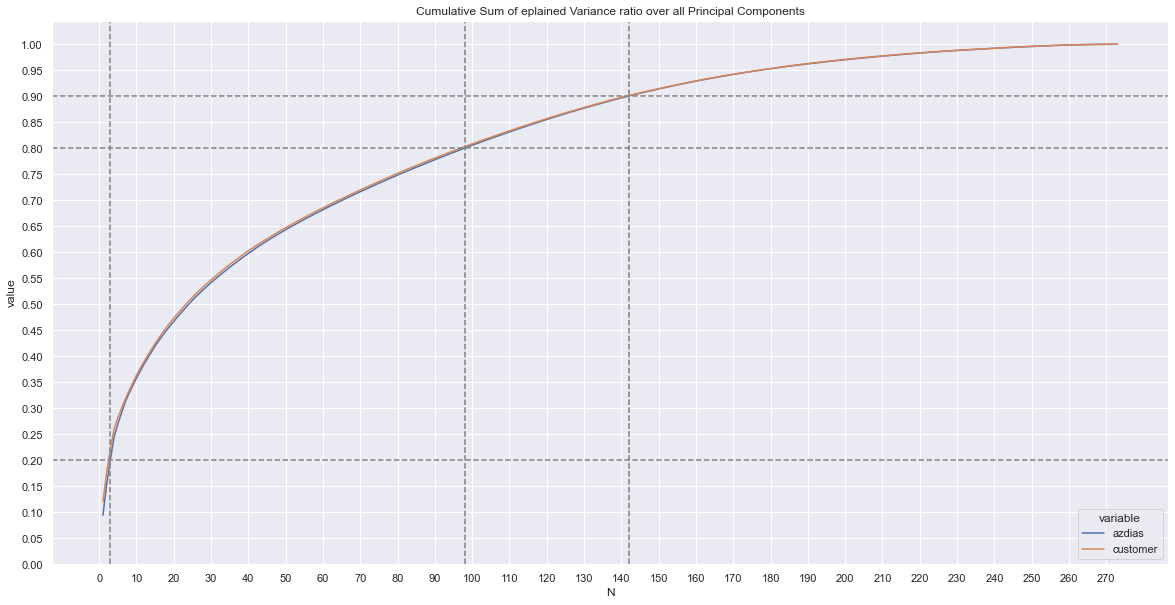

In [13]:
X_customer = np.cumsum(pca_customers.explained_variance_ratio_)
X_azdias = np.cumsum(pca_azdias.explained_variance_ratio_)

plot_data_cumsum = pd.DataFrame({'N': [i for i in range(1,len(X_azdias)+1)],'azdias': X_azdias, 'customer': X_customer})

sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
graph = sns.lineplot(data=pd.melt(plot_data_cumsum, ['N']), x='N', y='value', hue='variable')

graph.axhline(.9, ls='--', color='gray')
graph.axvline(142, ls='--', color='gray')
graph.axhline(.8, ls='--', color='gray')
graph.axvline(98, ls='--', color='gray')
graph.axhline(.2, ls='--', color='gray')
graph.axvline(3, ls='--', color='gray')
ax.set_xticks([i for i in range(len(X_azdias)+1) if i % 10 == 0])
ax.set_yticks([.0,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1])
graph.set_title(f'Cumulative Sum of eplained Variance ratio over all Principal Components')
plt.show()

The plot of the culumative sum also has three marked points:
* N=  3 of 273 components cover ~20% of the variance of azdias and ~22% of customers
* N= 98 of 273 components cover ~80% of the variance of azdias and customers
* N=142 of 273 components cover ~90% of the variance of azdias and customers

In [14]:
print(plot_data_cumsum[plot_data_cumsum['N']==142]) 
print('')
print(plot_data_cumsum[plot_data_cumsum['N']==98]) 
print('')
print(plot_data_cumsum[plot_data_cumsum['N']==5])
print('')
print(plot_data_cumsum[plot_data_cumsum['N']==4])
print('')
print(plot_data_cumsum[plot_data_cumsum['N']==3])

       N    azdias  customer
141  142  0.900517  0.901348

     N    azdias  customer
97  98  0.800374  0.803158

   N    azdias  customer
4  5  0.269586  0.281666

   N    azdias  customer
3  4  0.245136  0.260749

   N    azdias  customer
2  3  0.201126  0.221837


#### Plot the explained variance ratio of the first 50 components

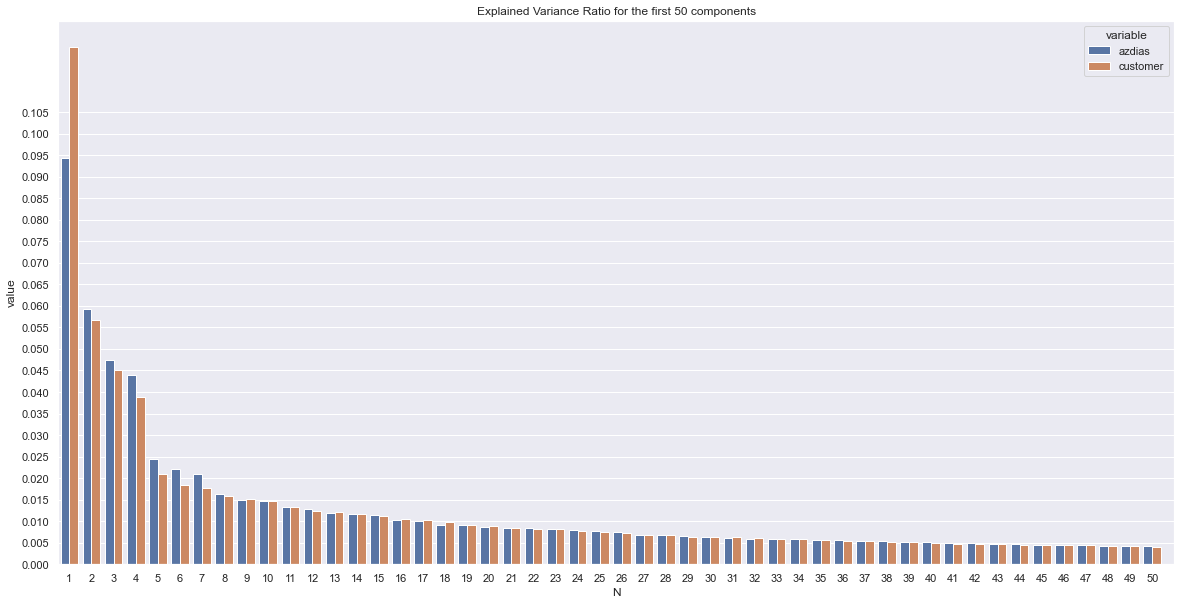

In [15]:
X_customer = pca_customers.explained_variance_ratio_
X_azdias = pca_azdias.explained_variance_ratio_

plot_data = pd.DataFrame({'N': [i for i in range(1,len(X_azdias)+1)],'azdias': X_azdias, 'customer': X_customer})

x_max=50
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
graph = sns.barplot(data=pd.melt(plot_data[plot_data['N']<=x_max], ['N']), x='N', y='value', hue='variable')

ax.set_xticks([n for n in range(x_max+1)])
ax.set_yticks([y for y in np.arange(0.0, 0.11, 0.005)])
graph.set_title(f'Explained Variance Ratio for the first {x_max} components')

plt.show()

**We will choose N=142 PCA components**

## Determine optimum k

We want to determine the optimum
first a few functions.

### Final PCA Transformer
We want to capture 90% of the data variance so we create a PCA transformer with N=142 components

In [16]:
scaled_azdias, scaled_customers = PreProcessor(root_path=root_path, out_dir=out_dirname).load_step_5_scaled_dfs()[0:2]

In [17]:
%%time
filename = f'{root_path}/{out_dirname}/03_pca.joblib'
pca = None
n_pca = 142
try:
    pca = load_model(filename)
    print(f'Loaded from {filename}')
except:
    pca = PCA(n_pca).fit(scaled_azdias)
    save_model(pca, filename)
print(pca)

azdias_in_pca_space = pca.transform(scaled_azdias)
customers_in_pca_space = pca.transform(scaled_customers)

PCA(n_components=142)
Wall time: 24 s


In [18]:
# define tuple with lower and upper value to search for K
num_clusters=(8,18)

### Elbow Method 

To save computing time use a subsample of azdias to determine the optimum k.

In [19]:
%%time
sample_size = 400000

# representative_sample(...) is provided in common_functions.py
test_data = representative_sample(numpy_array_to_df(azdias_in_pca_space), sample_size).values
filename = f'{root_path}/{out_dirname}/03_kmeans_test_data.joblib'
save_model(test_data, filename)

Wall time: 40.6 s


Save the result

In [20]:
test_data = load_model(f'{root_path}/{out_dirname}/03_kmeans_test_data.joblib')
test_data.shape

(400000, 142)

#### Create List of KMeans-Estimators
Create a list of tuples (k, fitted_K-Means_model_for_k) to save computing time. When calculating KMeans-Score or Silhouette-Score the fitted estimators can be reused.

In [21]:
%%time
max_iter = 180
kmeans_array = None
filename = f'{root_path}/{out_dirname}/03_fitted_k_means_list.joblib'

try:
    kmeans_array = load_model(filename)
except:
    print(test_data.shape)
    # fitted_k_mean_models(...) is provided in common_functions.py
    kmeans_array = fitted_k_mean_models(test_data, num_clusters, max_iter=max_iter)
    save_model(kmeans_array, filename)
print(kmeans_array)

(400000, 142)
Calculate Kmeans for 8 clusters.
Done in: 0:00:58.994856
Calculate Kmeans for 9 clusters.
Done in: 0:01:17.845338
Calculate Kmeans for 10 clusters.
Done in: 0:01:46.477197
Calculate Kmeans for 11 clusters.
Done in: 0:01:45.202777
Calculate Kmeans for 12 clusters.
Done in: 0:01:47.089329
Calculate Kmeans for 13 clusters.
Done in: 0:02:07.034483
Calculate Kmeans for 14 clusters.
Done in: 0:02:24.158184
Calculate Kmeans for 15 clusters.
Done in: 0:02:26.804753
Calculate Kmeans for 16 clusters.
Done in: 0:02:27.029521
Calculate Kmeans for 17 clusters.
Done in: 0:02:27.380827
Calculate Kmeans for 18 clusters.
Done in: 0:03:06.438680
[(8, KMeans(algorithm='elkan', max_iter=180)), (9, KMeans(algorithm='elkan', max_iter=180, n_clusters=9)), (10, KMeans(algorithm='elkan', max_iter=180, n_clusters=10)), (11, KMeans(algorithm='elkan', max_iter=180, n_clusters=11)), (12, KMeans(algorithm='elkan', max_iter=180, n_clusters=12)), (13, KMeans(algorithm='elkan', max_iter=180, n_clusters=1

#### Calculate KMeans-Score (SSE)
We calculate the Kmeans score by iterating through our previously generated list 'kmeans_array' and calling the score method of the contained Kmeans estimators.

In [22]:
%%time
# kmeans_scores(...) is provided in common_functions.py
sse = kmeans_scores(test_data, kmeans_array)

Calculate kmeans_scores (sse) for 8 clusters.
Score 74942264.0 Done in: 0:00:00.329627
Calculate kmeans_scores (sse) for 9 clusters.
Score 74132168.0 Done in: 0:00:00.398933
Calculate kmeans_scores (sse) for 10 clusters.
Score 73407664.0 Done in: 0:00:00.406912
Calculate kmeans_scores (sse) for 11 clusters.
Score 72787544.0 Done in: 0:00:00.395941
Calculate kmeans_scores (sse) for 12 clusters.
Score 72319840.0 Done in: 0:00:00.424891
Calculate kmeans_scores (sse) for 13 clusters.
Score 71812184.0 Done in: 0:00:00.421873
Calculate kmeans_scores (sse) for 14 clusters.
Score 71270776.0 Done in: 0:00:00.414889
Calculate kmeans_scores (sse) for 15 clusters.
Score 70861616.0 Done in: 0:00:00.418006
Calculate kmeans_scores (sse) for 16 clusters.
Score 70501896.0 Done in: 0:00:00.412896
Calculate kmeans_scores (sse) for 17 clusters.
Score 70175272.0 Done in: 0:00:00.407909
Calculate kmeans_scores (sse) for 18 clusters.
Score 69971592.0 Done in: 0:00:00.395108
Wall time: 4.45 s


In [23]:
filename = f'{root_path}/{out_dirname}/03_kmeans_minibatches_sse_scores.joblib'
save_model(sse, filename)

#### Elbow-Method 
We plot the kmeans scores to find the elbow.

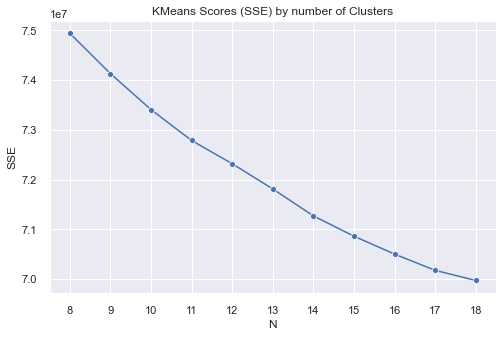

In [225]:
plot_data = pd.DataFrame.from_records(sse, columns=['N' ,'SSE'])
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (8,5))
graph = sns.lineplot(data=plot_data, x='N', y='SSE', marker='o')

ax.set_xticks([i[0] for i in sse])
ax.set_title("KMeans Scores (SSE) by number of Clusters")
plt.show()

&rArr; the elbow is not obvious so we will use further tools. We will examine the silhouette score.

### Examine the silhouette score

$$
silhouette = \frac{(b-a)}{max(a,b)} \\
$$

‘The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation)’ (https://en.wikipedia.org/wiki/Silhouette_(clustering)). It is calculated using the mean intra cluster distance (a) and the mean nearest-cluster distance (b) for each sample.

The values are in the interval [-1, 1]. ‘The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect’ (https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam)

&rArr; a high silhouette score is desirable


In [25]:
%%time
filename = f'{root_path}/{out_dirname}/03_fitted_k_means_list.joblib'
kmeans_array = load_model(filename)
# silhouette_scores(...) is provided in common_functions.py
silhouettes = silhouette_scores(test_data, kmeans_array, sample_size=60000)

Calculate silhouette_scores for 8 clusters.
Score 0.0005971227 , Done in: 0:01:19.572718
Calculate silhouette_scores for 9 clusters.
Score 0.006597072 , Done in: 0:01:21.168836
Calculate silhouette_scores for 10 clusters.
Score 0.009552384 , Done in: 0:01:22.499909
Calculate silhouette_scores for 11 clusters.
Score 0.008394056 , Done in: 0:01:21.366491
Calculate silhouette_scores for 12 clusters.
Score 0.016085047 , Done in: 0:01:25.876070
Calculate silhouette_scores for 13 clusters.
Score 0.014487374 , Done in: 0:01:20.070460
Calculate silhouette_scores for 14 clusters.
Score 0.017942306 , Done in: 0:01:24.495081
Calculate silhouette_scores for 15 clusters.
Score 0.02065641 , Done in: 0:01:22.114863
Calculate silhouette_scores for 16 clusters.
Score 0.018648813 , Done in: 0:01:24.189726
Calculate silhouette_scores for 17 clusters.
Score 0.02305767 , Done in: 0:01:21.298911
Calculate silhouette_scores for 18 clusters.
Score 0.021833258 , Done in: 0:01:18.858533
Wall time: 15min 1s


Store the result

In [26]:
filename = f'{root_path}/{out_dirname}/03_kmeans_minibatches_silhouette_scores.joblib'
save_model(silhouettes, filename)

Plot the data.

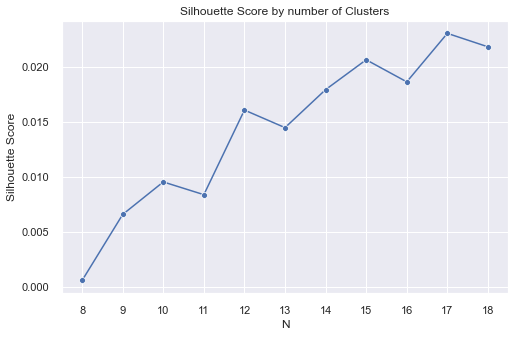

In [224]:
plot_data = pd.DataFrame.from_records(silhouettes, columns=['N' ,'Silhouette Score'])

sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
graph = sns.lineplot(data=plot_data, x='N', y='Silhouette Score', marker='o', ax=ax)

ax.set_title("Silhouette Score by number of Clusters")
ax.set_xticks([i[0] for i in silhouettes])
plt.show()

* The silhouette score is close to 0 so the clusters might be **overlappping** !!!!
* Maybe K-Means is close to its limits with that data... 
* It has a local maximum at N=17

&rArr; we use N=17 as optimum N

In [220]:
%%time
test_data = load_model(f'{root_path}/{out_dirname}/03_kmeans_test_data.joblib')
kmeans_array = load_model(f'{root_path}/{out_dirname}/03_fitted_k_means_list.joblib')
silhouettes = load_model(f'{root_path}/{out_dirname}/03_kmeans_minibatches_silhouette_scores.joblib')

Wall time: 194 ms


In [221]:
silhouettes

[(8, 0.0005971227),
 (9, 0.006597072),
 (10, 0.009552384),
 (11, 0.008394056),
 (12, 0.016085047),
 (13, 0.014487374),
 (14, 0.017942306),
 (15, 0.02065641),
 (16, 0.018648813),
 (17, 0.02305767),
 (18, 0.021833258)]

In [214]:
test_data_sihouette_visualizer = test_data[np.random.choice(test_data.shape[0], 80000, replace=False), :]

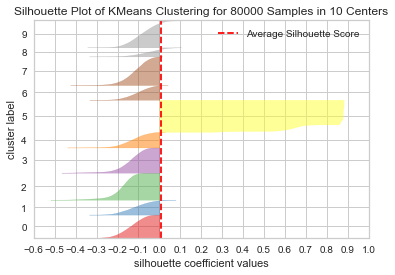

Wall time: 4min 56s


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 80000 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [215]:
%%time
custer_number = 10
model = [kmeans[1] for kmeans in kmeans_array if kmeans[0]==custer_number][0]
silhouette_visualizer = SilhouetteVisualizer(model)
silhouette_visualizer.fit(test_data_sihouette_visualizer)
silhouette_visualizer.show()

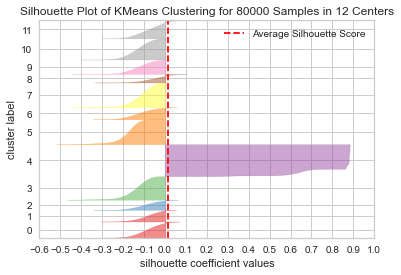

Wall time: 6min 28s


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 80000 Samples in 12 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [216]:
%%time
custer_number = 12
model = [kmeans[1] for kmeans in kmeans_array if kmeans[0]==custer_number][0]
silhouette_visualizer = SilhouetteVisualizer(model)
silhouette_visualizer.fit(test_data_sihouette_visualizer)
silhouette_visualizer.show()

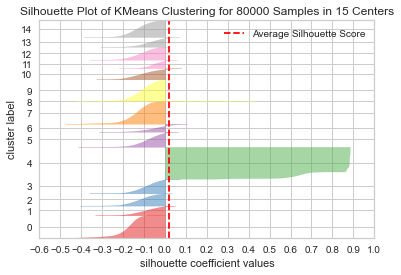

Wall time: 6min 26s


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 80000 Samples in 15 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [217]:
%%time
custer_number = 15
model = [kmeans[1] for kmeans in kmeans_array if kmeans[0]==custer_number][0]
silhouette_visualizer = SilhouetteVisualizer(model)
silhouette_visualizer.fit(test_data_sihouette_visualizer)
silhouette_visualizer.show()

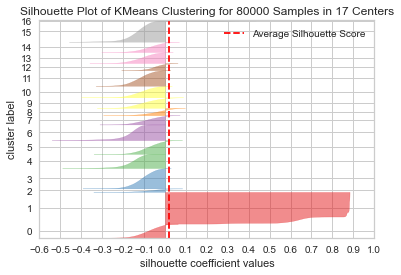

Wall time: 5min 29s


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 80000 Samples in 17 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [218]:
%%time
custer_number = 17
model = [kmeans[1] for kmeans in kmeans_array if kmeans[0]==custer_number][0]
silhouette_visualizer = SilhouetteVisualizer(model)
silhouette_visualizer.fit(test_data_sihouette_visualizer)
silhouette_visualizer.show()

In [226]:
n_clusters = 10

In [227]:
#del test_data

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Train the final KMeans predictor
Use the optimum k to fit the final K-Means predictor

In [31]:
## convenience cell for intermediate execution uncomment when needed
#scaled_azdias, scaled_customers = PreProcessor(root_path=root_path, out_dir=out_dirname).load_step_5_scaled_dfs()[0:2]

#ilename = f'{root_path}/{out_dirname}/03_pca.joblib'
#pca = load_model(filename)

#azdias_in_pca_space = pca.transform(scaled_azdias)
#customers_in_pca_space = pca.transform(scaled_customers)

#n_clusters = 10

Wall time: 7.44 s


In [228]:
%%time
filename = f'{root_path}/{out_dirname}/03_kmeans_opt.joblib'
kmeans_predictor = None
try:
    kmeans_predictor = load_model(filename)
    print(f'Loaded from {filename}')
except:
    kmeans_predictor = KMeans(n_clusters=n_clusters, random_state=31, verbose=0).fit(azdias_in_pca_space)
    save_model(kmeans_predictor, filename)
print(kmeans_predictor)

KMeans(n_clusters=10, random_state=31)
Wall time: 3min 3s


In [229]:
%%time
clustered_azdias = kmeans_predictor.predict(azdias_in_pca_space)
clustered_customers = kmeans_predictor.predict(customers_in_pca_space)

Wall time: 490 ms


Now we can visualize the cluster assignment for AZDIAS, CUSTOMERS by plotting bar chars...

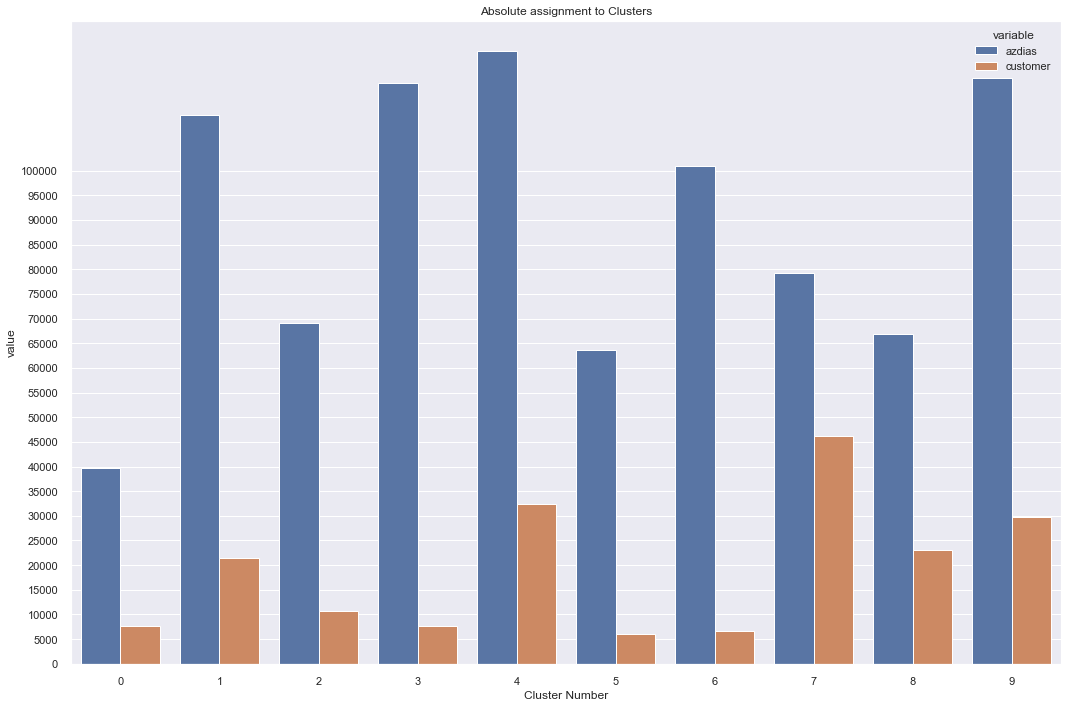

In [230]:
clustered_azdias_hist = pd.Series(clustered_azdias).value_counts(sort=False)
clustered_customers_hist = pd.Series(clustered_customers).value_counts(sort=False)

cust_list=list(clustered_customers_hist.values) 
plot_df=pd.DataFrame({'Cluster Number':list(clustered_azdias_hist.index), 
                      'azdias': list(clustered_azdias_hist.values),
                      'customer':cust_list,
                     })
sns.set_theme()
fig, (ax1) = plt.subplots(1, 1, figsize=(15,10))

graph = sns.barplot(data=pd.melt(plot_df, ['Cluster Number']), x='Cluster Number', y='value', hue='variable', ax=ax1)
graph.set_title("Absolute assignment to Clusters")
ax1.set_yticks([i*1000 for i in range(101) if i%5 == 0])

fig.tight_layout()
plt.show()

But absolute values make the clusters hard to compare. So we will plot the proportional cluster assignments... 

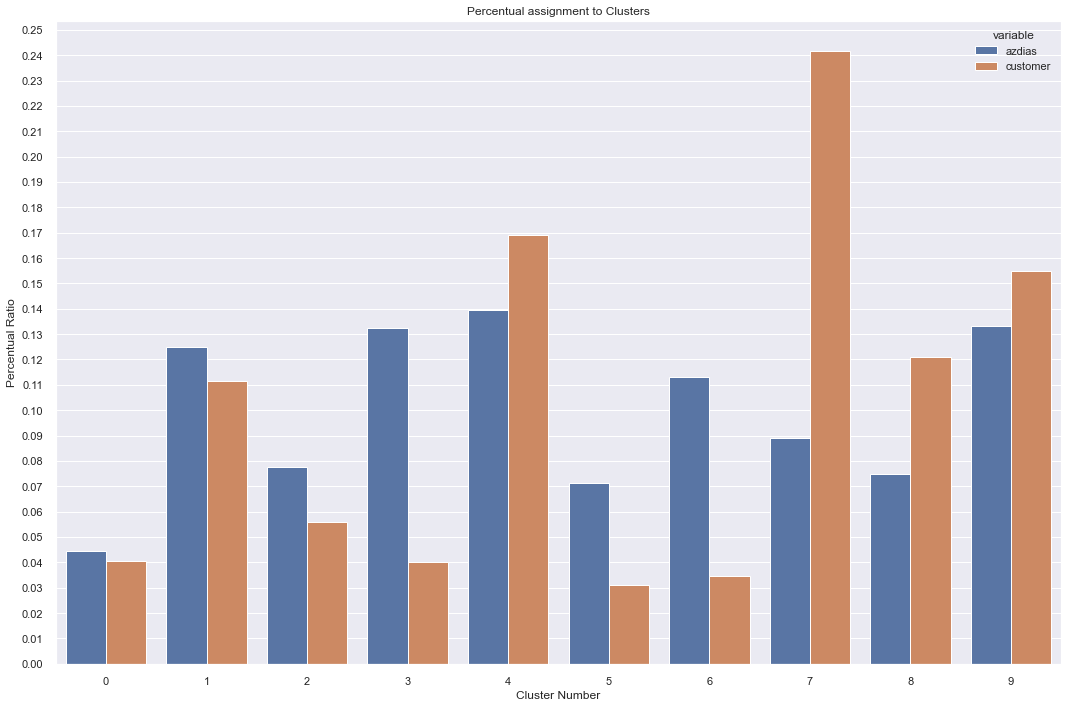

In [231]:
cust_list=list(clustered_customers_hist.values /  clustered_customers_hist.sum()) #list(clustered_customers_hist.values)[:6]+[0]+list(clustered_customers_hist.values)[6:]
plot_df=pd.DataFrame({'Cluster Number':list(clustered_azdias_hist.index), 
                      'azdias': list(clustered_azdias_hist.values / clustered_azdias_hist.sum()),
                      'customer': cust_list,
                     })
fig, (ax1) = plt.subplots(1, 1, figsize=(15,10))

graph = sns.barplot(data=pd.melt(plot_df, ['Cluster Number']), x='Cluster Number', y='value', hue='variable', ax=ax1)
ax1.set_title("Percentual assignment to Clusters")
ax1.set_yticks([i/100 for i in range(0,26)])
ax1.set_ylabel('Percentual Ratio')

fig.tight_layout()
plt.show()

* The clusters 4,7,8,9 are dominated by CUSTOMERS. 
    * The clusters **7 and 8** show the highest domination of CUSTOMERS. 
* The clusters 0,1,2,3,5,6 are dominated by AZDIAS
    * the clusters 2,3,5,6 show the Highest domination Of AZDIAS
    
&rArr; we will investigate on clusters 2 and 8 from CUSTOMERS and compare each with [2,3,5,6] from AZDIAS.

In [232]:
customer_cluster_ids = [7,8] 
azdias_cluster_ids = [2,3,5,6]

### Centroids in Component Space

We want to get an impression of how many of the pca components tu use. Therefore, we plot a heatmap of the Cluster centroids vs. the PCA components.


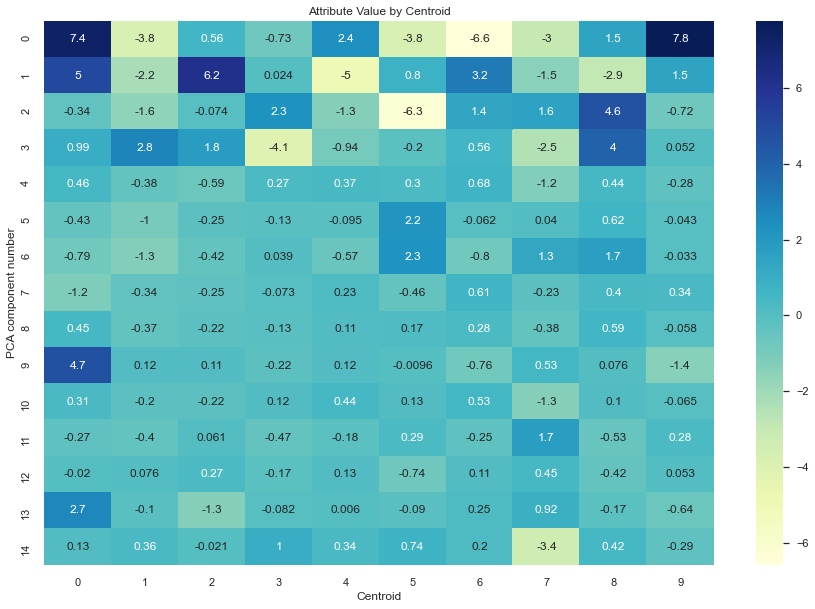

In [233]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(kmeans_predictor.cluster_centers_.T[:15,:], annot=True, cmap="YlGnBu")
ax.set_xlabel("Centroid")
ax.set_ylabel("PCA component number")
ax.set_title("Attribute Value by Centroid")

plt.show()

* the plot gets greener and greener the higher the component index that means
* looks like the first five components are most important

### PCA factor loadings

In [234]:
def display_factor_loads(components, features_list, component_numbers=[0,1,2,3,4,5,6,7,8], n_weights=12, total_cols=3):
    """
    Plot the factor-loadings of PCA components
    :param components: The _components attribute of a PCA transformer
    :param features_list: List with the feature names 
    :param component_numbers: List of the indexes of the PCA components
    :param n_weights: number of weights (original features) to include
    :param total_cols: number of columns of the plots
    """
    sns.set_theme()
    num_plots=len(component_numbers)
    additional_row = 1 if num_plots%total_cols > 0 else 0 
    total_rows = num_plots//total_cols + additional_row

    fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                            figsize=(7*total_cols, 7*total_rows), 
                            constrained_layout=True)

    for i, component_num in enumerate(component_numbers):
        row = i//total_cols
        pos = i % total_cols
        
        comps = pd.DataFrame(list(zip(np.squeeze(components[component_num, :]), features_list)), 
                             columns=['weights', 'features'])

        # we'll want to sort by the largest n_weights
        # weights can be neg/pos and we'll sort by magnitude
        comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
        sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

        #ax=plt.subplots(figsize=figsize)
        sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features",
                   ax=axs[row][pos],
                   palette="Blues_d"
                   )
        axs[row][pos].set_title(f"PCA Component Makeup, Component #{component_num}")

    plt.show()

We will plot the factor loadings of the first 6 PCA components to see how they are made up by the original features.

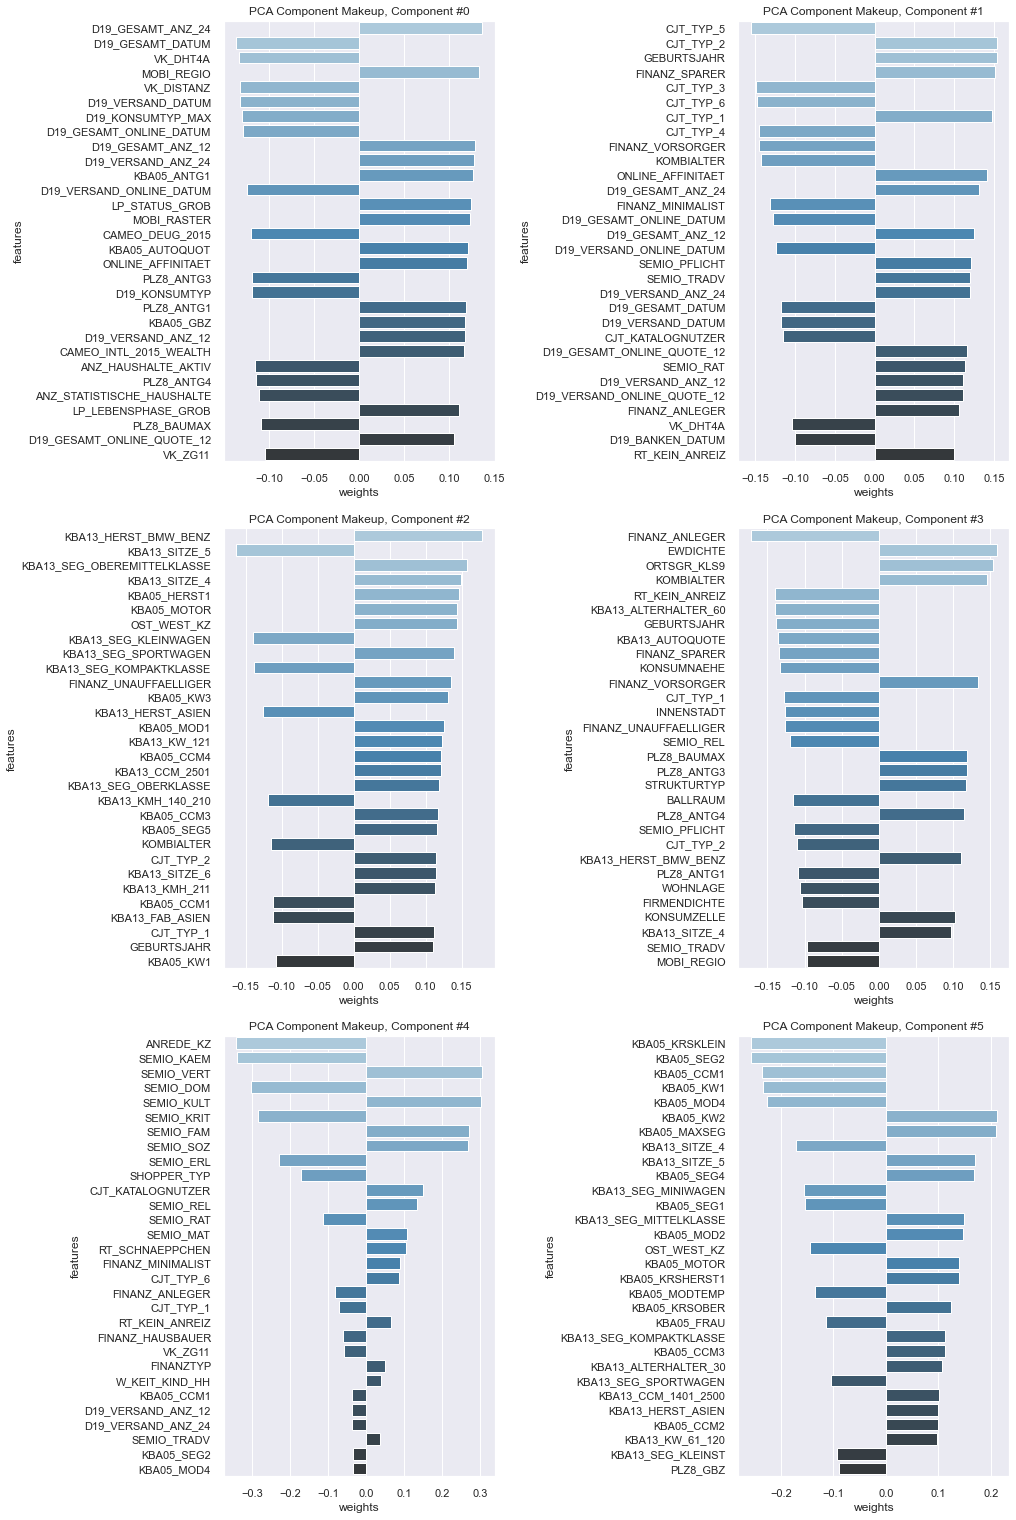

In [235]:
display_factor_loads(pca.components_, scaled_customers.columns.values, component_numbers=[0,1,2,3,4,5],n_weights=30, total_cols=2)

## Analysis - Results

After looking at the factor loading we create a list of distinct features ordered by their weight in the factor loadings.
* We use the *generate_relevant_features(...)* function. 
* The factor loads of the first five components serve as input.

In [236]:
def factor_load_of_component_df(components, features_list, component_num, n_weights=10): 
    """
    Create a DataFrame with factor loadings of a PCA component.
    :param components: The _components attribute of a PCA transformer
    :param features_list: List with the feature names 
    :param component_num: the index of the PCA component
    :param n_weights: number of weights (original features) to include
    """
    comps = pd.DataFrame(list(zip(np.squeeze(components[component_num, :]), features_list)), 
                         columns=['weights', 'features'])
    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    comps['component_num']=component_num
    return comps.sort_values('abs_weights', ascending=False).head(n_weights)


def generate_relevant_features(factor_load_dfs):
    """
    Utility function to get list of tuples (featurename, pca_component_number). The objective is to have each feature
    apear max once in a plot of PCA components. 
    :param factor_load_dfs: list of DataFrames genrated by the factor_load_of_component_df(...) function.
    :return: list
    """
    results = []
    features = set([])
    component_nums = []
    for df in factor_load_dfs:
        for _, row in df.iterrows():
            if not row['features'] in features:
                results.append((row['features'], row['component_num']))
                features.add(row['features'])
    return results
        

def extended_pca_df(df_in_pca_space, scaled_df, kmeans_predictor, scaler, feature_engineer):
    """
    Utility function to retrieve the clusterd dataset in the original space by given dataframe in PCA-space
    :param df_in_pca_space: The DataFrame in pca_space
    :param scaled_df: original, scaled dataframe before transformed by PCA
    :return: DataFrame in the original space
    """
    predcited_clusters = kmeans_predictor.predict(df_in_pca_space)
    data=scaler.inverse_transform(scaled_df)
    unscaled_df = pd.DataFrame(data, index=scaled_df.index, columns=scaled_df.columns).round(0)
    unscaled_df['cluster_num'] = predcited_clusters
    return unscaled_df

def plot_hists(customers, azdias, column_names, documentation=documentation, labels=['customers', 'azdias'], 
               title_prefix='Feature', total_cols=2, use_proprtions=True):
    """
    Convenience function to generate matrix plots. Each single plot shows two histograms of one feature in the AZDIAS and the CUSTOMERS df.  
    :param customers: the customersd DataFrame
    :param azdias: the azdias DataFrame
    :param column_names: list of the columns we are interested in
    :param documentation: the documentation object
    :param labels: labels to display for the dataframes
    :param title_prefix: prefix for the title of the plot
    :param total_cols: number of columns of the plot-matrix
    :param use_proprtions: y-axis-scaling use proportions (percentual values) or absolute values
    :return: Nothing - the function plots directly
    """
    sns.set_theme()
    num_plots=len(column_names)
    additional_row = 1 if num_plots % total_cols > 0 else 0
    total_rows = max(1, num_plots // total_cols + additional_row)

    fig, (axs) = plt.subplots(nrows=total_rows, ncols=total_cols,
                            figsize=(9*total_cols, 7*total_rows),
                            constrained_layout=True)

    for i, column_name in enumerate(column_names):
        row = i//total_cols
        pos = i % total_cols
        current_ax = axs[row][pos]
        df = prepare_data_for_plot_hists(customers, azdias, column_name, labels=labels)
        graph = sns.barplot(data=df, x='index', y='value', hue='variable', ax=current_ax)
        current_ax.set_title(f"{title_prefix} {column_name}")
        current_ax.set_xlabel(column_name)
        current_ax.set_xticklabels(
            xticklabels_for_plot_hists(column_name, documentation, axs[row][pos].get_xticklabels()),
            rotation=90
        )
        current_ax.set_ylabel('count')

    plt.show()
    
def prepare_data_for_plot_hists(customers, azdias, column_name, use_proprtions=True, labels=['customers', 'azdias']):
    """
    prepare data for the plot_hists(...) function...
    :param customers: the customersd DataFrame
    :param azdias: the azdias DataFrame
    :param column_name: the column we are interested in
    :param use_proprtions: y-axis-scaling use proportions (percentual values) or absolute values
    :param labels: labels to display for the dataframes
    :return: melted DataFrame
    """
    customers_vcounts = customers[column_name].value_counts()
    azdias_vcounts = azdias[column_name].value_counts()
    combined_index = customers_vcounts.sort_values().combine(
                azdias_vcounts.sort_values(), max, fill_value=0
    ).keys()
    df = pd.DataFrame(index=combined_index)
    if use_proprtions:
        df[labels[1]] = df.join(azdias_vcounts / azdias_vcounts.sum()).fillna(0)
        df[labels[0]] = df.join(customers_vcounts / customers_vcounts.sum())[column_name].fillna(0)
    else:
        df[labels[1]] = df.join(azdias_vcounts).fillna(0)
        df[labels[0]] = df.join(customers_vcounts)[column_name].fillna(0)
    result = pd.melt(df.reset_index(), ['index'])
    return result
 
def xticklabels_for_plot_hists(column_name, documentation, xticklabels, numbers_as_int=False):
    """
    Generate xticklabels for plot_hists(...) function. Look up documentation for textual description.
    Otherwise return numeric value...
    :param column_name: the column we are interested in
    :param documentation: the documentation object
    """
    dct = documentation.meta_dict
    if column_name in dct:
        for xticklabel in xticklabels:
            txt = xticklabel.get_text()
            if is_numeric(txt):
                i = float(txt)
                if i in dct[column_name]['items']:
                    xticklabel.set_text(dct[column_name]['items'][i])
                else:
                    if numbers_as_int:
                        xticklabel.set_text(int(i))                        
    return xticklabels


def label_as_str(label, mod=5):
    """
    Utility function for plotting when there are too many labels on an axis...
    """
    return str(label) if label and float(str(label)) % mod == 0 else ''       

### Analysis
We can do alot of things with the data in order to gain valuable information from the clustering. 
What we will do is compare the two highest customers-dominated clusters against the clusters dominated by AZDIAS.
These clusters are 7 and 8:
* Evaluate cluster 7 against the AZDIAS-dominated clusters
* Evaluate cluster 8 against the AZDIAS-dominated clusters
* Comparison is done visually using the histograms of features
    * Again we compare percentual values

First we have to some preprocessing again:
* Transform the data back from the PCA-Space into our orginal space.
    * We also keep the cluster number as an additional column
* Determine the relevant features from the factor loadings
* Plot histograms for the relevant features

In [237]:
# load the scalers
azdias_scaler, customer_scaler = PreProcessor(root_path=root_path, out_dir=out_dirname).load_scalers()[0:2]

Next we determine the relevant features. We take the first five pricipal components and consider important features we got from the factor loadings. The number of features to consider per component was determined by reviewing the plots of the factor loadings:
* The first 30 features of component 0
* The first 27 features of component 1
* The first 23 features of component 2
* The first 20 features of component 3
* The first 10 features of component 4

In [238]:
# the n_weights values are taken from the factor loadings (visually)
relev_features = generate_relevant_features([
    factor_load_of_component_df(pca.components_, scaled_customers.columns.values, component_num=0, n_weights=30),
    factor_load_of_component_df(pca.components_, scaled_customers.columns.values, component_num=1, n_weights=27),
    factor_load_of_component_df(pca.components_, scaled_customers.columns.values, component_num=2, n_weights=23),
    factor_load_of_component_df(pca.components_, scaled_customers.columns.values, component_num=3, n_weights=20),
    factor_load_of_component_df(pca.components_, scaled_customers.columns.values, component_num=4, n_weights=10),
])


Let's transform the clustered dataframes back into the original space. Also keep the cluster number

In [239]:
%%time
untransformed_customers = extended_pca_df(customers_in_pca_space, scaled_customers,  kmeans_predictor, customer_scaler, feature_engineer)
untransformed_customers = untransformed_customers[untransformed_customers['cluster_num'].isin(customer_cluster_ids)]

Wall time: 5.08 s


In [240]:
%%time
untransformed_azdias = extended_pca_df(azdias_in_pca_space, scaled_azdias,  kmeans_predictor, azdias_scaler, feature_engineer)
untransformed_azdias = untransformed_azdias[untransformed_azdias['cluster_num'].isin(azdias_cluster_ids)]

Wall time: 23.8 s


In [241]:
print(untransformed_azdias.shape)
print(untransformed_customers.shape)

(351357, 274)
(69445, 274)


Before starting the comparison, let's look at the feature GEBURTSJAHR of the clusters dominated by CUSTOMERS versus the clusters dominated by AZDIAS: 

Text(0, 0.5, 'count')

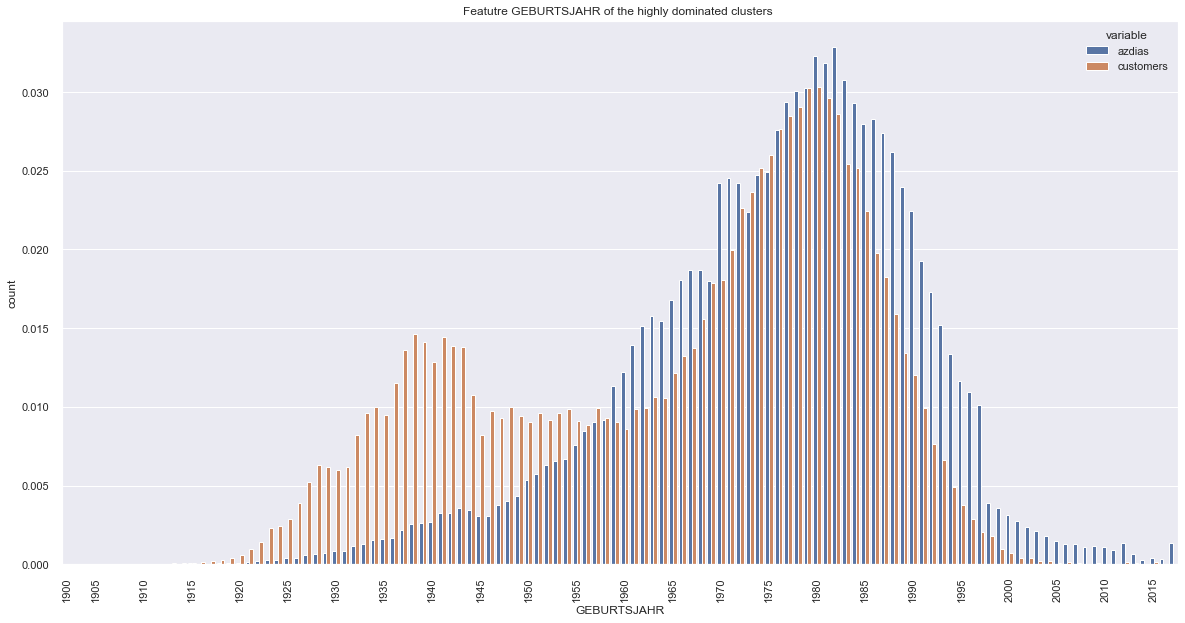

In [242]:
plot_feature = 'GEBURTSJAHR' 
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
df = prepare_data_for_plot_hists(
    untransformed_customers, 
    untransformed_azdias, 
    plot_feature, 
    use_proprtions=True
)
sns.barplot(data=df, x='index', y='value', hue='variable', ax=ax)
ax.set_title(f"Featutre {plot_feature} of the highly dominated clusters ")
ax.set_xlabel(plot_feature)
xticklabels = xticklabels_for_plot_hists(plot_feature, documentation, ax.get_xticklabels(), numbers_as_int=True)
ax.set_xticklabels([label_as_str(label._text) for label in xticklabels] ,rotation=90)
ax.set_ylabel('count')

* Cutomers Histogram is M-shaped
* Regarding older people the proportions of Customers is much higher than for AZDIAS

Next let's do the same, but now we compare the CUSTOMERS clusters separately against AZDIAS
We start with cluster numer 7:

Text(0, 0.5, 'count')

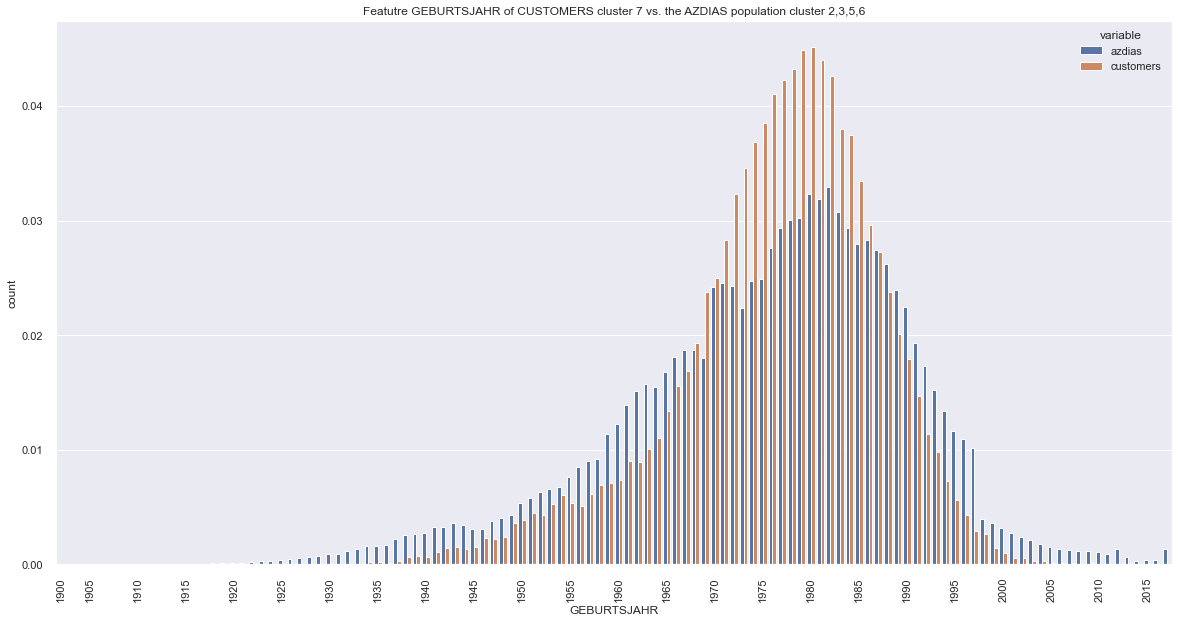

In [367]:
plot_feature = 'GEBURTSJAHR'
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
df = prepare_data_for_plot_hists(
    untransformed_customers[untransformed_customers['cluster_num']==7], 
    untransformed_azdias, 
    plot_feature, 
    use_proprtions=True
)
sns.barplot(data=df, x='index', y='value', hue='variable', ax=ax)
ax.set_title(f"Featutre {plot_feature} of CUSTOMERS cluster 7 vs. the AZDIAS population cluster 2,3,5,6")
ax.set_xlabel(plot_feature)
xticklabels = xticklabels_for_plot_hists(plot_feature, documentation, ax.get_xticklabels(), numbers_as_int=True)
ax.set_xticklabels([label_as_str(label._text) for label in xticklabels] ,rotation=90)
ax.set_ylabel('count')

In [245]:
untransformed_customers[untransformed_customers['cluster_num']==7]['GEBURTSJAHR'].describe()

count    46283.000000
mean      1976.479126
std         10.565969
min       1930.000000
25%       1971.000000
50%       1978.000000
75%       1984.000000
max       2012.000000
Name: GEBURTSJAHR, dtype: float64

And now CUSTOMERS cluster number 8 vs. AZDIAS...

Text(0, 0.5, 'count')

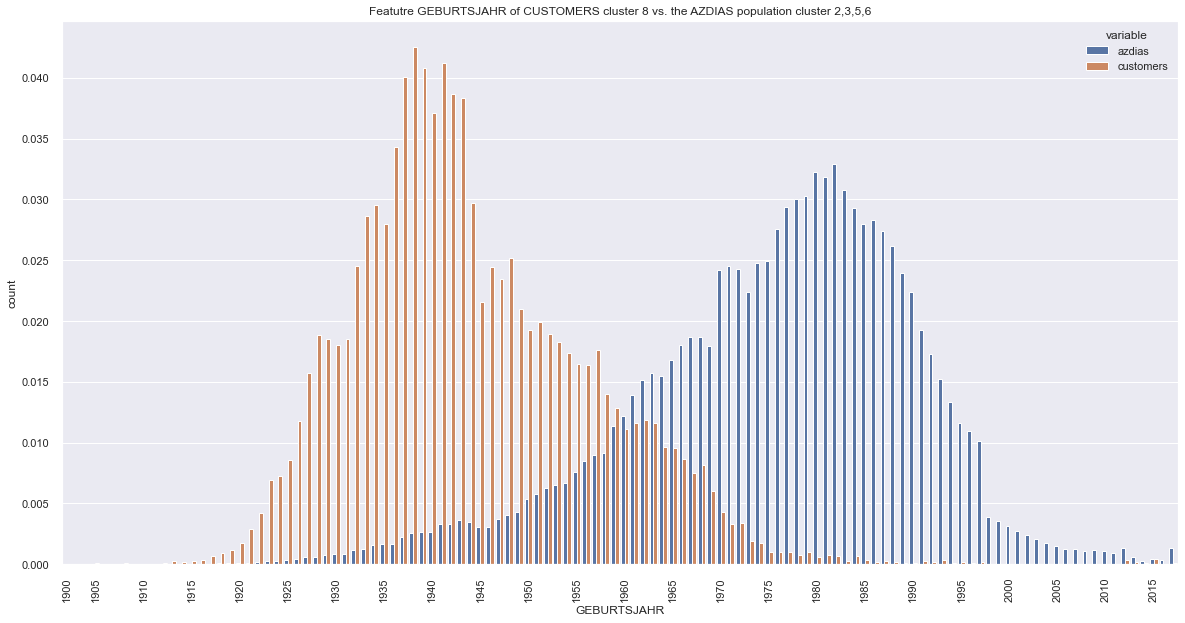

In [366]:
plot_feature = 'GEBURTSJAHR'
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
df = prepare_data_for_plot_hists(
    untransformed_customers[untransformed_customers['cluster_num']==8], 
    untransformed_azdias, 
    plot_feature, 
    use_proprtions=True
)
sns.barplot(data=df, x='index', y='value', hue='variable', ax=ax)
ax.set_title(f"Featutre {plot_feature} of CUSTOMERS cluster 8 vs. the AZDIAS population cluster 2,3,5,6")
ax.set_xlabel(plot_feature)
xticklabels = xticklabels_for_plot_hists(plot_feature, documentation, ax.get_xticklabels(), numbers_as_int=True)
ax.set_xticklabels([label_as_str(label._text) for label in xticklabels] ,rotation=90)
ax.set_ylabel('count')

In [246]:
untransformed_customers[untransformed_customers['cluster_num']==8]['GEBURTSJAHR'].describe()

count    23162.000000
mean      1944.012085
std         12.389095
min       1900.000000
25%       1936.000000
50%       1942.000000
75%       1952.000000
max       2017.000000
Name: GEBURTSJAHR, dtype: float64

**Conclusion:**
    
Ok that was very informative.
* Looks like the two CUSTOMER-clusters refer two different groups of age...

## Evaluation 1 (Cluster 8)

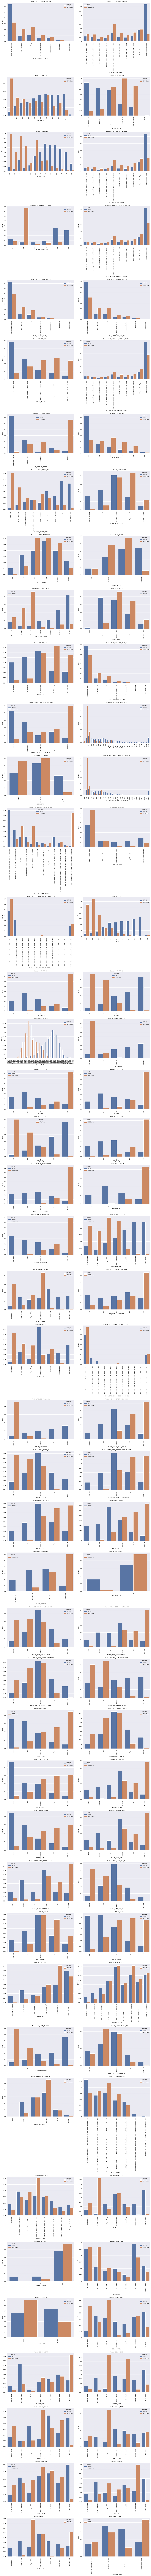

Wall time: 4min 53s


In [247]:
%%time
plot_hists(untransformed_customers[untransformed_customers['cluster_num'] == 8], untransformed_azdias, [feature[0] for feature in relev_features])

### Result

Here the observations:

* Middle to very low mobility with concentration on low - moving pattern     (MOBI_REGIO)
* Older Average Year of Birth 1944 (stddev approx 12 years) (GEBURTSJAHR)
* Rather low Transaction activity (pool) in last 12 month  (D19_GESAMT_ANZ_12)
* Rather low Transaction activity (pool) in last 24 month  (D19_GESAMT_ANZ_24)
* Slightly increased mailordeing activity within the last 12 month (D19_GESAMT_DATUM)
* Rather male rough ratio male/female approx 71/29   (ANREDE_KZ)
* Last online transaction rather 1-3 years  (D19_VERSAND_ONLINE_DATUM, D19_VERSAND_DATUM)   
* Social status rather wealthy (mainly independants to top earners, concentration on top earners) (LP_STATUS_GROB)
* Rather Aveage or High or very High car quote per household (concentration on High) (KBA05_AUTOQUOT)
* Consumption Type (Universal, Versatile, Gourmet mainly gourmet)   (D19_KONSUMTYP)
* Average to High to very high share of 1-2 Family Houses (with concentration around High) (KBA05_ANTG1)   
* Low to average share of 6-10 family houses (PLZ8_ANTG3)
* ONLINE_AFFINITY rather high (mainly middle, high, very high with concentration around high) (ONLINE_AFFINITAET)
* Mainly upper class/upper middleclass/established middleclass   (CAMEO_DEUG_2015)
* Rather wealthy  (CAMEO_INT_2015_WEALTH)
* Mainly high income earners (singles, couples, and households)(LP_LEBENSPHASE_GROB)
* Very high share of money savers (FINANZ_SPARER)
* Highly financially interested (FINANZ_MINIMALIST)
* Mainly very high affinity towards financial investment             (FINANZ_ANLEGER)
* High to ver y high share of Luxury cars of the brands MERCEDES, BMW (KBA13_HERST_BMW_BENZ)
* High share of Cars with big engines  (KBA05_MOTOR)
* High share of sports cars   (KBA13_SEG_SPORTWAGEN)
* Mainly West germany approx 98% (OST_WEST_KZ)
* Density of inhabitans per km2 rather high with 150 to 999+  (EWDICHTE)
* Not too far away from city center (mainly) (INNENSTADT)
* Rather religious (SEMIO_REL)
* Not very dreamily (SEMIO_VERT)
* Critically minded (SEMIO_KRIT)
* Mainly not dreamily minded at all
* Rather not family minded (SEMIO_FAM)
* Very eventfully minded (SEMIO_ERL)
* Demanding shopper  (SHOPPER_TYP)


## Evaluation 2 (Cluster 7)

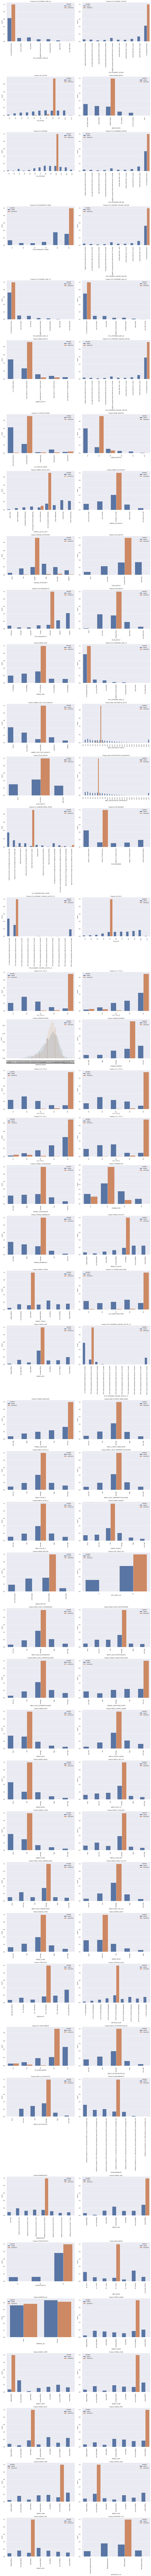

Wall time: 5min 4s


In [248]:
%%time
plot_hists(untransformed_customers[untransformed_customers['cluster_num'] == 7], untransformed_azdias, [feature[0] for feature in relev_features])

### Result


* Slightly more female (ratio approx. 52/48)  (ANREDE_KZ)
* Younger average age born 1976 std dev 10 years (GEBURTSJAHR)
* Middle mobility    (MOBI_REGIO)
* Mostly no transacions known regarding mail-order activities (D19_... features)
* Mainly average earners but also a few top earners, independants, houseowners  (LP_STATUS_GROB)
* Modern consuption type  (D19_KONSUMTYP)
* Mainly lower share of 1-2 family homes (KBA05_ANTG1)
* 5-16 Buildings in the cell (KBA05_GBZ)
* Average share of 6-10 family houses (PLZ8_ANTG3)
* Consumption Type Informed   (D19_KONSUMTYP)
* Middle online affinity (ONLINE_AFFINITAET)
* Low consumption middle class (~95%), active middle class(~5%)     (CAMEO_DEUG_2015)
* Comfortable wealth         (CAMEO_INT_2015_WEALTH)
* 7 households in the building  (ANZ_HAUSHALTE_AKTIV)
* Low share of number of >10 family houses in the PLZ8 (PLZ8_ANTG4)
* High share of single high-income and earner couples and high earner  (LP_LEBENSPHASE_GROB)
* Common building type 3-5 family homes (PLZ8_BAUMAX)
* Low affinity to money saving  (FINANZ_SPARER)
* Low affinity towards dutifull traditional minded (SEMIO_PFLICHT)
* High affinity traditionally minded  (SEMIO_TRADV)
* Average affinity rationally minded (SEMIO_RAT)
* 10% online transactions within the last 12 month (D19_GESAMT_ONLINE_QUOTE_12)
* Very low affinity to finacial invests (FINANZ_ANLEGER)
* 10% online transactions mailorder in the last 12 months(D19_VERSAND_ONLINE_QUOTE_12)
* Western germany 100%  (OST_WEST_KZ)
* Low to average share of luxury cars MERCEDES, BMW (KBA13_HERST_BMW_BENZ, KBA05_HERST1)
* town size 20000 to  50000 (ORTSGR_KLS9)
* Density 150 to 319 HH/km2     (EWDICHTE)
* 10-20 km to the city centre  (INNENSTADT)
* Not religious at all   (SEMIO_REL)
* 30-40 km to next big city (BALLRAUM)
* Low share of upper class cars (KBA05_MOD1)   
* low share of cars with big engine size (KBA05_CCM4)
* very dreamily persons (SEMIO_VERT)
* high affinity cultural stuff   (SEMIO_KULT)
* Not critically minded at all (SEMIO_KRIT)
* Very social minded  (SEMIO_SOZ)
* Very low affinity familiar minded (SEMIO_FAM)
* High affinity to events (SEMIO_ERL)
* family shopper  (SHOPPER_TYP)


Text(0, 0.5, 'count')

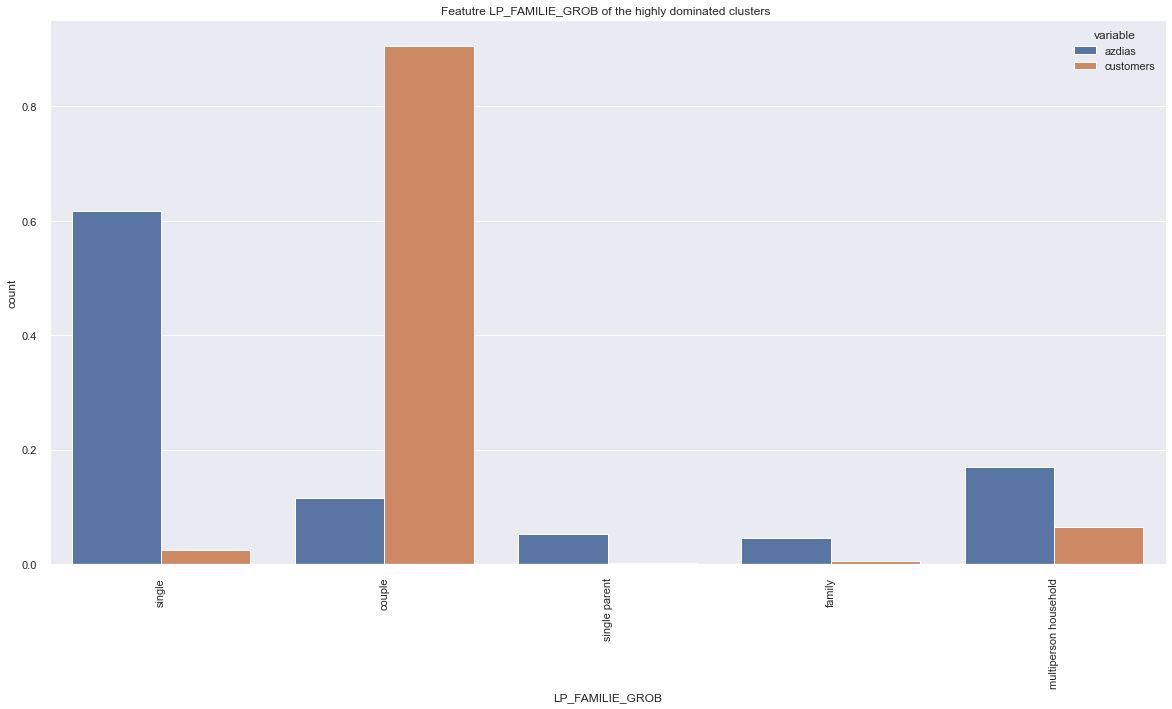

In [249]:
plot_feature = 'LP_FAMILIE_GROB' 
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
df = prepare_data_for_plot_hists(
    untransformed_customers[untransformed_customers['cluster_num']==7], 
    untransformed_azdias, 
    plot_feature, 
    use_proprtions=True
)
sns.barplot(data=df, x='index', y='value', hue='variable', ax=ax)
ax.set_title(f"Featutre {plot_feature} of the highly dominated clusters ")
ax.set_xlabel(plot_feature)
xticklabels = xticklabels_for_plot_hists(plot_feature, documentation, ax.get_xticklabels(), numbers_as_int=True)
ax.set_xticklabels(xticklabels ,rotation=90)
ax.set_ylabel('count')

&rArr; Cluster 7 contains mainly couples and multiperson households

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [264]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

#from featureengineering import Documentation, FeatureEngineer, PreProcessor
#from common_functions import is_numeric, load_dataframe, save_dataframe, load_model, save_model

from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score 
from sklearn import metrics
from xgboost import XGBClassifier
import xgboost as xgb

In [251]:
root_path='.'
out_dirname = 'tmp_results'
models_dirname = 'models'
export_dir = f'{root_path}/{models_dirname}'
Path(export_dir).mkdir(parents=True, exist_ok=True)

In [252]:
estimator_filenames = {
    'benchmark': f'{models_dirname}/us-03_raw-benchmark-clf.joblib',
    'xgb': f'{models_dirname}/us-03_raw-xgb-finetuned-clf.joblib',
    'mlp': f'{models_dirname}/us-03_raw-mlp-clf.joblib',
    'logreg': f'{models_dirname}/us-03_raw-logistic-clf.joblib',
    'extra': f'{models_dirname}/us-03_raw-ext-clf.joblib',
}

train_val_filenames = {
    'x_train': f'{models_dirname}/x-train-us-raw-80-20.joblib',
    'x_val': f'{models_dirname}/x-val-us-raw-80-20.joblib',
    'y_train': f'{models_dirname}/y-train-us-raw-80-20.joblib',
    'y_val': f'{models_dirname}/y-val-us-raw-80-20.joblib'
}

kaggle_filenames = {
    'benchmark': f'{models_dirname}/kaggle-submission-benchmark_raw-clf.csv',
    'xgb': f'{models_dirname}/kaggle-submission-xgb_raw-clf.csv',
    'mlp': f'{models_dirname}/kaggle-submission-mlp_raw-clf.csv',
    'logreg': f'{models_dirname}/kaggle-submission-logreg_raw-clf.csv',
    'extra': f'{models_dirname}/kaggle-submission-ext_raw-clf.csv',
}
roc_scores = {
    'benchmark': (0, 0),
    'extra': (0, 0),
    'xgb': (0, 0),
    'mlp': (0, 0),
    'logreg': (0, 0),
}

In [253]:
%%time

pre_processor = PreProcessor(root_path=root_path, out_dir=out_dirname)
azdias, customers, mailout_train, mailout_test = pre_processor.load_step_4_imputed_dfs()
target_col = pre_processor.load_target_variable()

Wall time: 6.84 s


In [254]:
len(target_col[target_col==1]) / target_col.shape[0]

0.012383036171500396

&rArr; Ratio between class '0' and the minority class '1' is roughly 99:1. That means we have a severe imbalance.

In [255]:
%%time
X = mailout_train
y = list(target_col)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Wall time: 77.8 ms


In [256]:
save_model(X_train, train_val_filenames['x_train'])
save_model(X_val,   train_val_filenames['x_val'])
save_model(y_train, train_val_filenames['y_train'])
save_model(y_val,   train_val_filenames['y_val'])

In [257]:
X_train = load_model(train_val_filenames['x_train'])
X_val = load_model(train_val_filenames['x_val'])
y_train = load_model(train_val_filenames['y_train'])
y_val = load_model(train_val_filenames['y_val'])

In [258]:
predictor_column_names=[col for col in mailout_train.columns if col != 'RESPONSE']

train_df = pd.DataFrame(X_train, columns=predictor_column_names)
train_df['RESPONSE'] = y_train
train_df

AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_PERSONEN  \
LNR                                                    
36580         1.0                  1.0           2.0   
24424         1.0                  1.0           7.0   
19946         1.0                  1.0           2.0   
31541         1.0                 12.0           2.0   
20427         1.0                  1.0           3.0   
...           ...                  ...           ...   
62357         1.0                  9.0           1.0   
85531         2.0                  5.0           1.0   
82376         1.0                  1.0           4.0   
47360         1.0                  4.0           3.0   
45674         1.0                  6.0           0.0   

       ANZ_STATISTISCHE_HAUSHALTE  ARBEIT  BALLRAUM  CAMEO_DEUG_2015  \
LNR                                                                    
36580                         1.0     1.0       2.0              2.0   
24424                         1.0     3.0       6.0              4.0   
19946                         1.0     2.0       3.0              2.0   
31541                        11.0     3.0       1.0              6.0   
20427                         1.0     3.0       6.0              2.0   
...                           ...     ...       ...              ...   
62357                         9.0     4.0       7.0              5.0   
85531                         4.0     4.0       1.0              5.0   
82376                         1.0     2.0       6.0              3.0   
47360                         5.0     3.0       4.0              5.0   
45674                         8.0     4.0       2.0              8.0   

       CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
LNR                                                                        
36580            4.0                3.0        2.0        3.0        4.0   
24424            5.0                1.0        3.0        2.0        4.0   
19946            2.0                3.0        1.0        1.0        5.0   
31541            2.0                5.0        3.0        3.0        2.0   
20427            5.0                3.0        2.0        2.0        4.0   
...              ...                ...        ...        ...        ...   
62357            2.0                5.0        2.0        1.0        5.0   
85531            2.0                5.0        1.0        1.0        5.0   
82376            2.0                1.0        2.0        2.0        4.0   
47360            4.0                1.0        2.0        1.0        5.0   
45674            6.0                5.0        1.0        2.0        5.0   

       CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
LNR                                                                            
36580        4.0        5.0        2.0                0.0                0.0   
24424        4.0        3.0        4.0                1.0                1.0   
19946        5.0        5.0        5.0                0.0                0.0   
31541        4.0        3.0        4.0                0.0                0.0   
20427        4.0        5.0        4.0                0.0                0.0   
...          ...        ...        ...                ...                ...   
62357        5.0        5.0        5.0                0.0                0.0   
85531        5.0        5.0        5.0                0.0                0.0   
82376        4.0        5.0        5.0                0.0                0.0   
47360        5.0        5.0        5.0                0.0                0.0   
45674        5.0        5.0        5.0                0.0                0.0   

       D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  \
LNR                                                            
36580              10.0                0.0               0.0   
24424               3.0                3.0               6.0   
19946              10.0                0.0             

In [350]:
n_jobs = 4
model_names={
    'benchmark': 'Random Forest (Benchmark)',
    'extra': 'Extra Trees',
    'xgb': 'XGBoost',
    'mlp': 'Multi Layer Perceptron',
    'logreg': 'Logistic Regression',
}

## Tune Benchmark (Randomforest)
See also https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn .

In [272]:
%%time
rv = RandomForestClassifier(
        n_estimators=200,
        max_features=100,
        max_depth=9,
        random_state=42,
        class_weight='balanced',
        verbose=2)

gs_benchmark = GridSearchCV(
    estimator=rv, 
    param_grid={
    }, 
    scoring="roc_auc", 
    cv=5, 
    n_jobs=n_jobs, 
    verbose=2
)
gs_benchmark.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   48.4s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=9, max_features=100,
                                              n_estimators=200, random_state=42,
                                              verbose=2),
             n_jobs=4, param_grid={}, scoring='roc_auc', verbose=2)

In [273]:
gs_benchmark.best_estimator_, gs_benchmark.best_params_, gs_benchmark.best_score_

(RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=100,
                        n_estimators=200, random_state=42, verbose=2),
 {},
 0.7438340482436914)

In [274]:
save_model(gs_benchmark.best_estimator_, estimator_filenames['benchmark'])
print(gs_benchmark.best_estimator_)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=100,
                       n_estimators=200, random_state=42, verbose=2)


In [279]:
%%time

model = load_model(estimator_filenames['benchmark'])
roc_scores['benchmark'] = (
    roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
    roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
)
print(model)
print('Classification-Report on training data:\n', classification_report(y_train, model.predict(X_train)))
print('Confusion-Matrix on training data:\n',confusion_matrix(y_train, model.predict(X_train)))
print('ROC score on training data:', roc_scores['benchmark'][0])
print('Classification-Report on validation data:\n', classification_report(y_val, model.predict(X_val)))
print('Confusion-Matrix on training data:\n',confusion_matrix(y_val, model.predict(X_val)))
print('ROC score on validation data:', roc_scores['benchmark'][1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=100,
                       n_estimators=200, random_state=42, verbose=2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Classification-Report on training data:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92     33943
           1       0.07      0.91      0.13       426

    accuracy                           0.85     34369
   macro avg       0.53      0.88      0.52     34369
weighted avg       0.99      0.85      0.91     34369



[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


Confusion-Matrix on training data:
 [[28752  5191]
 [   38   388]]
ROC score on training data: 0.9570708087114838
Classification-Report on validation data:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      8487
           1       0.04      0.50      0.07       106

    accuracy                           0.84      8593
   macro avg       0.52      0.67      0.49      8593
weighted avg       0.98      0.84      0.90      8593

Confusion-Matrix on training data:
 [[7182 1305]
 [  53   53]]
ROC score on validation data: 0.7836752547180927
Wall time: 2.6 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


## Tune Extratrees Classifier

see also https://machinelearningmastery.com/extra-trees-ensemble-with-python/

In [288]:
%%time
ext1 = ExtraTreesClassifier(
        random_state=42,
        class_weight='balanced',
        verbose=2)

gs_ext1 = GridSearchCV(
    estimator = ext1, 
    param_grid = {
        'n_estimators': [200, 250], # the higher the less overfirtting
        'max_features': [80, 100, 120],  # start with ~ 30-50%
    }, 
    scoring = "roc_auc", 
    cv = 5, 
    n_jobs = n_jobs, 
    verbose=2
)
gs_ext1.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 12.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 250


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.6min finished


GridSearchCV(cv=5,
             estimator=ExtraTreesClassifier(class_weight='balanced',
                                            random_state=42, verbose=2),
             n_jobs=4,
             param_grid={'max_features': [80, 100, 120],
                         'n_estimators': [200, 250]},
             scoring='roc_auc', verbose=2)

In [289]:
gs_ext1.best_estimator_, gs_ext1.best_params_, gs_ext1.best_score_

(ExtraTreesClassifier(class_weight='balanced', max_features=100,
                      n_estimators=250, random_state=42, verbose=2),
 {'max_features': 100, 'n_estimators': 250},
 0.6866402647604127)

In [290]:
bm_n_estimators = gs_ext1.best_params_['n_estimators']
bm_max_features = gs_ext1.best_params_['max_features'] 

In [291]:
%%time
ext2 = ExtraTreesClassifier(
        n_estimators=bm_n_estimators,
        max_features=bm_max_features,
        random_state=42,
        class_weight='balanced',
        verbose=2)

gs_ext2 = GridSearchCV(
    estimator = ext2, 
    param_grid = {
        'max_depth': [9, 12, 15], 
        'min_samples_split': [2, 3, 4] # greater than one
    }, 
    scoring = "roc_auc", 
    cv = 5, 
    n_jobs = 4, 
    verbose=2
)
gs_ext2.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 13.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 250


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   56.3s finished


GridSearchCV(cv=5,
             estimator=ExtraTreesClassifier(class_weight='balanced',
                                            max_features=100, n_estimators=250,
                                            random_state=42, verbose=2),
             n_jobs=4,
             param_grid={'max_depth': [9, 12, 15],
                         'min_samples_split': [2, 3, 4]},
             scoring='roc_auc', verbose=2)

In [292]:
gs_ext2.best_estimator_, gs_ext2.best_params_, gs_ext2.best_score_

(ExtraTreesClassifier(class_weight='balanced', max_depth=9, max_features=100,
                      min_samples_split=3, n_estimators=250, random_state=42,
                      verbose=2),
 {'max_depth': 9, 'min_samples_split': 3},
 0.7508972289926032)

In [293]:
save_model(gs_ext2.best_estimator_, estimator_filenames['extra'])
print(gs_ext2.best_estimator_)

ExtraTreesClassifier(class_weight='balanced', max_depth=9, max_features=100,
                     min_samples_split=3, n_estimators=250, random_state=42,
                     verbose=2)


In [82]:
#del gs_benchmark1, gs_benchmark2, ext1, ext2

## Eval on validation set

In [294]:
%%time

model = load_model(estimator_filenames['extra'])
roc_scores['extra'] = (
    roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
    roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
)
print(model)
print('Classification-Report on training data:\n', classification_report(y_train, model.predict(X_train)))
print('Confusion-Matrix on training data:\n',confusion_matrix(y_train, model.predict(X_train)))
print('ROC score on training data:', roc_scores['extra'][0])
print('Classification-Report on validation data:\n', classification_report(y_val, model.predict(X_val)))
print('Confusion-Matrix on training data:\n',confusion_matrix(y_val, model.predict(X_val)))
print('ROC score on validation data:', roc_scores['extra'][1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


ExtraTreesClassifier(class_weight='balanced', max_depth=9, max_features=100,
                     min_samples_split=3, n_estimators=250, random_state=42,
                     verbose=2)


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Classification-Report on training data:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89     33943
           1       0.05      0.89      0.10       426

    accuracy                           0.81     34369
   macro avg       0.53      0.85      0.50     34369
weighted avg       0.99      0.81      0.88     34369



[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Confusion-Matrix on training data:
 [[27447  6496]
 [   48   378]]
ROC score on training data: 0.9655708361670677


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Classification-Report on validation data:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      8487
           1       0.04      0.60      0.07       106

    accuracy                           0.80      8593
   macro avg       0.52      0.70      0.48      8593
weighted avg       0.98      0.80      0.88      8593

Confusion-Matrix on training data:
 [[6839 1648]
 [  42   64]]
ROC score on validation data: 0.7897183483729834
Wall time: 3.58 s


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished


## Tune XGBOOST

* idea taken from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ and 
https://github.com/aarshayj/analytics_vidhya/blob/master/Articles/Parameter_Tuning_XGBoost_with_Example/XGBoost%20models.ipynb


In [295]:
# adapted from https://github.com/aarshayj/analytics_vidhya/blob/master/Articles/Parameter_Tuning_XGBoost_with_Example/XGBoost%20models.ipynb
# train_df training data  as pandas df
# dtest test data as pandas df

def xgb_modelfit(xgb_classifier, train_df, predictor_column_names, 
                 target_column_name='RESPONSE', use_train_cv=True,              
                 cv_folds=5, early_stopping_rounds=50,              
                 generate_plot=True, figsize=(17,10)):
    """
    Train XGB Model using tools from the xgboost library. 
    :param xgb_classifier: the xgb-classifier
    :param train_df: training data as pandas DataFrame
    :param predictor_column_names: th relevant column names in the training set
    :param target_column_name: Name of the target column
    :param use_train_cv: Boolean indication if cross validation should be used for training
    :param cv_folds: number of cross-validation folds
    :param early_stopping_rounds: early_stopping_rounds parameter of the 
    :param generate_plot:
    :param figsize:
    :return: The result of xgb's cv function for cross-validation it can be used to determine optimum number of estimators...
    """
    
    if use_train_cv:
        xgb_param = xgb_classifier.get_xgb_params()
        xgtrain = xgb.DMatrix(train_df[predictor_column_names].values, label=train_df[target_column_name].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb_classifier.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        xgb_classifier.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    xgb_classifier.fit(train_df[predictor_column_names], train_df[target_column_name], eval_metric='auc')
    
    #Predict training set:
    train_df_predictions = xgb_classifier.predict(train_df[predictor_column_names])
    train_df_predprob = xgb_classifier.predict_proba(train_df[predictor_column_names])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train_df[target_column_name].values, train_df_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train_df[target_column_name], train_df_predprob))
    
    
    feat_imp = pd.Series(xgb_classifier.get_booster().get_fscore()).sort_values(ascending=True)
    print("Number of important features:", len(feat_imp))
    if generate_plot:
        sns.set_theme()
        feat_imp.plot(kind='barh', title='Feature Importances', figsize=figsize)
        plt.ylabel('Feature Importance Score')
    return cvresult

## Step 1: Find learning_rate, scale_pos_weight and n_estimators

We will start with initial versions of *learning_rate* and *n_estimators*

In [296]:
tmp_learning_rate = 0.08 # 0.05

Define scale_pos_weight for imbalanced learning 

In [297]:
# see https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
# scale_pos_weight = total_negative_examples / total_positive_examples
scale_pos_weight = len([y for y in y_train if y<=0]) / len([y for y in y_train if y>=1])


Model Report
Accuracy : 0.7266
AUC Score (Train): 0.882414
Number of important features: 189
Wall time: 20.9 s


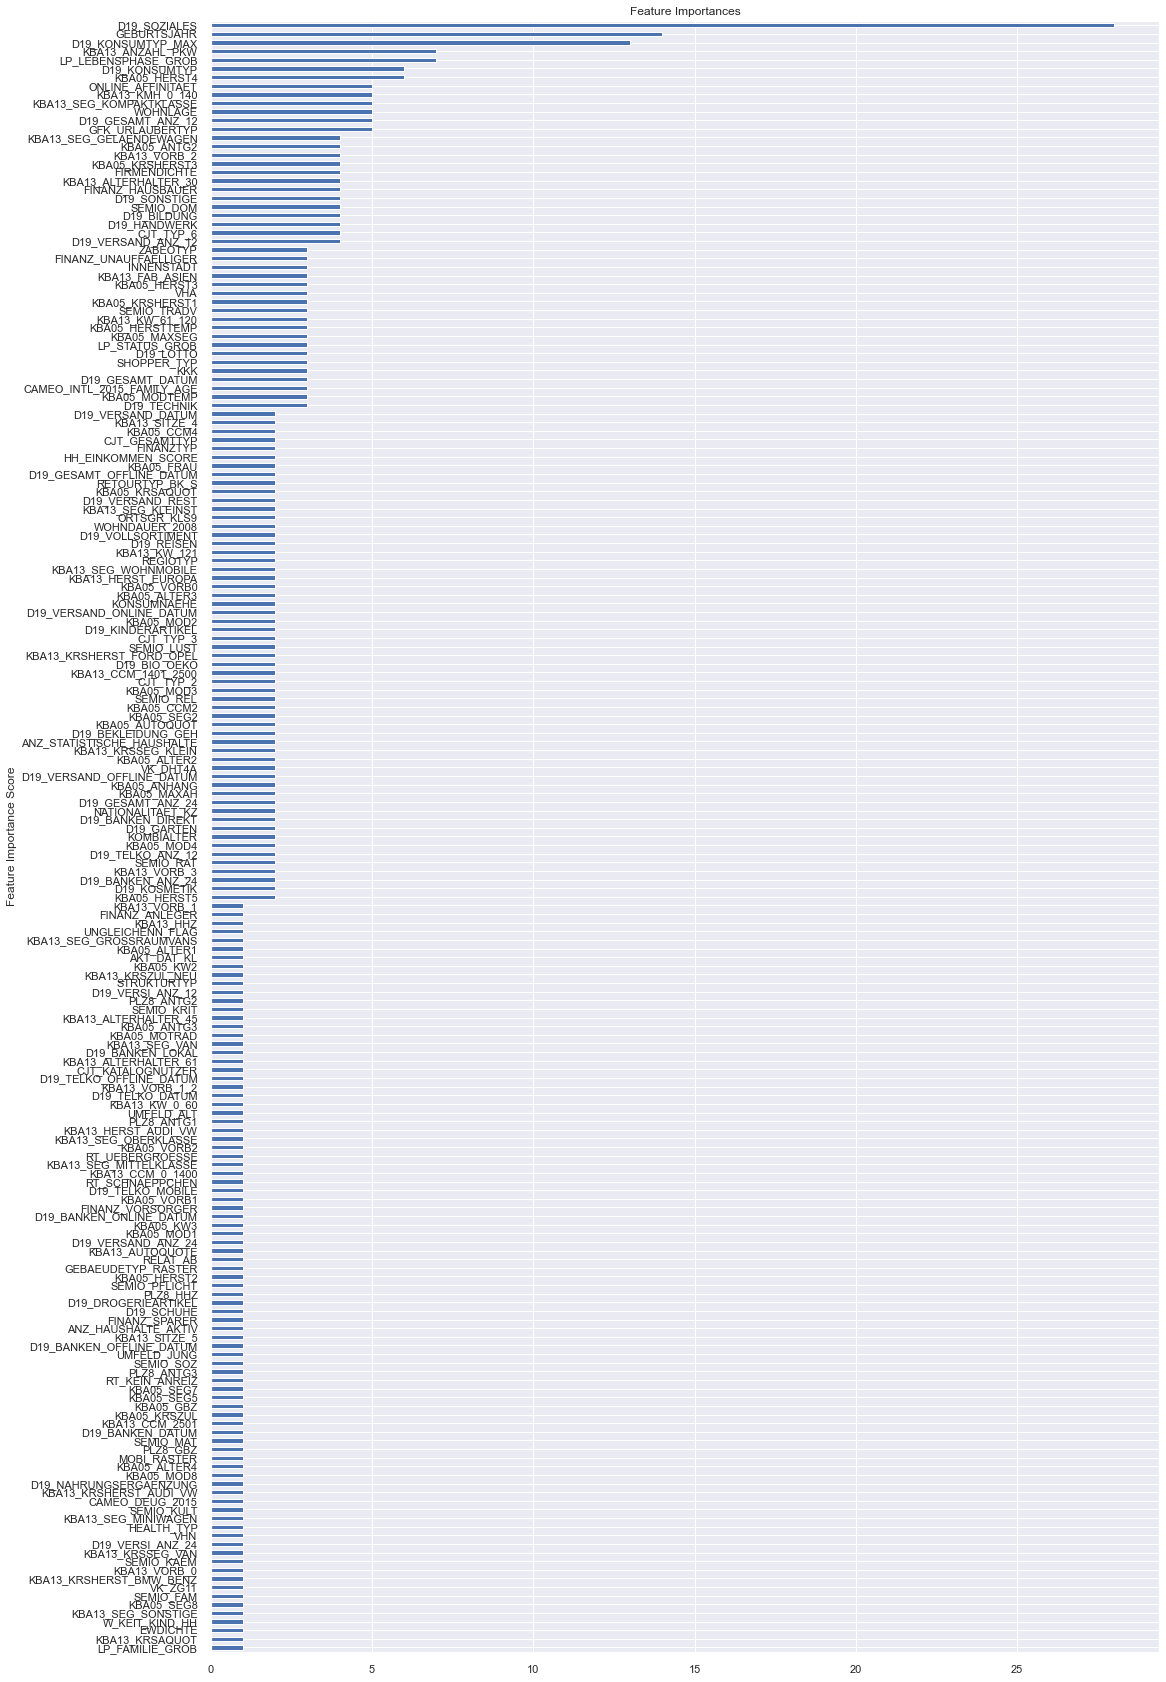

In [299]:
%%time
xgb1 = XGBClassifier(
    learning_rate=tmp_learning_rate,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=scale_pos_weight,
    seed=27,
    nthread=n_jobs,
    use_label_encoder=False,
    verbosity=1
)
mf = xgb_modelfit(xgb1, train_df, predictor_column_names, figsize=(17,30))

In [300]:
mf.shape

(17, 4)

In [301]:
tmp_n_estimators = mf.shape[0]

## Step2: Tune max_depth and min_child_weight 


min_child_weight [default=1]
* Defines the minimum sum of weights of all observations required in a child.
* This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
* Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
* Too high values can lead to under-fitting hence, it should be tuned using CV.

max_depth [default=6]
* The maximum depth of a tree, same as GBM.
* Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
* Should be tuned using CV.
* Typical values: 3-10


For further information see https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [302]:
learning_rate = tmp_learning_rate
n_estimators = tmp_n_estimators

In [303]:
%%time
xgb2 = XGBClassifier( 
    learning_rate=learning_rate, 
    n_estimators=n_estimators,  
    gamma=0, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
gsearch2 = GridSearchCV(
    estimator=xgb2, 
    param_grid={
        'max_depth': [2, 3, 4], 
        'min_child_weight': [1, 2, 3]
    }, 
    scoring='roc_auc',
    n_jobs=4,
    verbose=2, 
    cv=5
)
gsearch2.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   23.1s finished


[01:17:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 24.2 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.08, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=17, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=79.67840375586854,
                                     seed=27, subsa

In [304]:
gsearch2.best_estimator_, gsearch2.best_params_, gsearch2.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.08, max_delta_step=0, max_depth=2,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=17, n_jobs=4, nthread=4, num_parallel_tree=1,
               random_state=27, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=79.67840375586854, seed=27, subsample=0.8,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=1),
 {'max_depth': 2, 'min_child_weight': 1},
 0.7619475310889768)

## Step 3: Tune Gamma

gamma [default=0]
* A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
* Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.

For further information see https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [305]:
min_child_weight = gsearch2.best_params_['min_child_weight'] 
max_depth = gsearch2.best_params_['max_depth']

In [306]:
%%time
xgb3 = XGBClassifier( 
    learning_rate=learning_rate, 
    n_estimators=n_estimators, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    subsample=0.8, 
    colsample_bytree=0.8, 
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
gsearch3 = GridSearchCV(
    estimator=xgb3, 
    param_grid={
        'gamma':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }, 
    scoring='roc_auc',
    n_jobs=n_jobs,
    verbose=2, 
    cv=5
)
gsearch3.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed:   19.3s finished


[01:19:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 20.3 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.08, max_delta_step=None,
                                     max_depth=2, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=17, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=79.67840375586854,
                                     seed=27, subsampl

In [307]:
gsearch3.best_estimator_, gsearch3.best_params_, gsearch3.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8, gamma=0.0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.08, max_delta_step=0, max_depth=2,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=17, n_jobs=4, nthread=4, num_parallel_tree=1,
               random_state=27, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=79.67840375586854, seed=27, subsample=0.8,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=1),
 {'gamma': 0.0},
 0.7619475310889768)

## Step 4: Tune subsample and colsample_bytree


subsample [default=1]
* Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
* Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
* Typical values: 0.5-1

colsample_bytree [default=1]
* Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
* Typical values: 0.5-1

In [308]:
gamma = gsearch3.best_params_['gamma'] 

In [309]:
%%time
xgb4 = XGBClassifier( 
    learning_rate=learning_rate, 
    n_estimators=n_estimators, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma = gamma,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
gsearch4 = GridSearchCV(
    estimator=xgb4, 
    param_grid={
        'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }, 
    scoring='roc_auc',
    n_jobs=n_jobs,
    verbose=2, 
    cv=5
)
gsearch4.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   56.6s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  1.1min finished


[01:20:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1min 9s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.08, max_delta_step=None,
                                     max_depth=2, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=17, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=79.67840375586854,
                                     seed=27, subsampl

In [310]:
gsearch4.best_estimator_, gsearch4.best_params_, gsearch4.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.9, gamma=0.0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.08, max_delta_step=0, max_depth=2,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=17, n_jobs=4, nthread=4, num_parallel_tree=1,
               random_state=27, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=79.67840375586854, seed=27, subsample=0.7,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=1),
 {'colsample_bytree': 0.9, 'subsample': 0.7},
 0.7655668771501589)

## Step 5: Tuning Regularization Parameters

In [311]:
subsample = gsearch4.best_params_['subsample']
colsample_bytree = gsearch4.best_params_['colsample_bytree']

In [312]:
%%time
xgb5 = XGBClassifier( 
    learning_rate=learning_rate, 
    n_estimators=n_estimators, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
gsearch5 = GridSearchCV(
    estimator=xgb5, 
    param_grid={
        'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }, 
    scoring='roc_auc',
    n_jobs=n_jobs,
    verbose=2, 
    cv=5
)
gsearch5.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    9.5s finished


[01:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 10.6 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.08, max_delta_step=None,
                                     max_depth=2, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=17, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=79.67840375586854,
                                     seed=27, subsample

In [313]:
gsearch5.best_estimator_, gsearch5.best_params_, gsearch5.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.9, gamma=0.0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.08, max_delta_step=0, max_depth=2,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=17, n_jobs=4, nthread=4, num_parallel_tree=1,
               random_state=27, reg_alpha=100, reg_lambda=1,
               scale_pos_weight=79.67840375586854, seed=27, subsample=0.7,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=1),
 {'reg_alpha': 100},
 0.7663874138471897)

In [314]:
%%time
xgb6 = XGBClassifier( 
    learning_rate=learning_rate, 
    n_estimators=n_estimators, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
gsearch6 = GridSearchCV(
    estimator=xgb6, 
    param_grid={
        'reg_alpha':[100, 300, 500, 800, 1000]
    }, 
    scoring='roc_auc',
    n_jobs=n_jobs,
    verbose=2, 
    cv=5
)
gsearch6.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    9.8s finished


[01:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 10.9 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.08, max_delta_step=None,
                                     max_depth=2, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=17, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=79.67840375586854,
                                     seed=27, subsample

In [315]:
gsearch6.best_estimator_, gsearch6.best_params_, gsearch6.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.9, gamma=0.0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.08, max_delta_step=0, max_depth=2,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=17, n_jobs=4, nthread=4, num_parallel_tree=1,
               random_state=27, reg_alpha=300, reg_lambda=1,
               scale_pos_weight=79.67840375586854, seed=27, subsample=0.7,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=1),
 {'reg_alpha': 300},
 0.7665866043726163)

## Step 7 Finalize Learning rate Add more trees 

In [316]:
reg_alpha = gsearch6.best_params_['reg_alpha']

### Try learning_rate=0.01

In [318]:
%%time
xgb7 = XGBClassifier( 
    learning_rate=0.01, 
    n_estimators=5000, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    reg_alpha=reg_alpha,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
mf=xgb_modelfit(xgb7, train_df, predictor_column_names, cv_folds=5, generate_plot=False)


Model Report
Accuracy : 0.587
AUC Score (Train): 0.776408
Number of important features: 33
Wall time: 28.8 s


Try learning_rate=0.02

In [319]:
%%time
xgb7 = XGBClassifier( 
    learning_rate=0.02, 
    n_estimators=5000, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    reg_alpha=reg_alpha,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
mf=xgb_modelfit(xgb7, train_df, predictor_column_names, cv_folds=5, generate_plot=False)


Model Report
Accuracy : 0.5949
AUC Score (Train): 0.781243
Number of important features: 35
Wall time: 23.1 s


Try learning_rate=0.03

In [321]:
%%time
xgb7 = XGBClassifier( 
    learning_rate=0.03, 
    n_estimators=5000, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    reg_alpha=reg_alpha,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
mf=xgb_modelfit(xgb7, train_df, predictor_column_names, cv_folds=5, generate_plot=False)


Model Report
Accuracy : 0.7246
AUC Score (Train): 0.801665
Number of important features: 90
Wall time: 34.5 s


Try learning_rate=0.035

In [326]:
%%time
xgb7 = XGBClassifier( 
    learning_rate=0.035, 
    n_estimators=5000, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    reg_alpha=reg_alpha,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
mf=xgb_modelfit(xgb7, train_df, predictor_column_names, cv_folds=5, generate_plot=False)


Model Report
Accuracy : 0.7276
AUC Score (Train): 0.830622
Number of important features: 173
Wall time: 1min 11s


Try learning_rate=0.038

In [329]:
%%time
xgb7 = XGBClassifier( 
    learning_rate=0.038, 
    n_estimators=5000, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    reg_alpha=reg_alpha,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
mf=xgb_modelfit(xgb7, train_df, predictor_column_names, cv_folds=5, generate_plot=False)


Model Report
Accuracy : 0.7309
AUC Score (Train): 0.839701
Number of important features: 190
Wall time: 1min 22s


Try learning_rate=0.04

In [322]:
%%time
xgb7 = XGBClassifier( 
    learning_rate=0.04, 
    n_estimators=5000, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    reg_alpha=reg_alpha,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
mf=xgb_modelfit(xgb7, train_df, predictor_column_names, cv_folds=5, generate_plot=False)


Model Report
Accuracy : 0.7252
AUC Score (Train): 0.829344
Number of important features: 162
Wall time: 57 s


Try learning_rate=0.05

In [323]:
%%time
xgb7 = XGBClassifier( 
    learning_rate=0.05, 
    n_estimators=5000, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    reg_alpha=reg_alpha,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
mf=xgb_modelfit(xgb7, train_df, predictor_column_names, cv_folds=5, generate_plot=False)


Model Report
Accuracy : 0.7254
AUC Score (Train): 0.817916
Number of important features: 124
Wall time: 38.7 s


&rArr; use learning_rate=0.038


Model Report
Accuracy : 0.7309
AUC Score (Train): 0.839701
Number of important features: 190
Wall time: 1min 23s


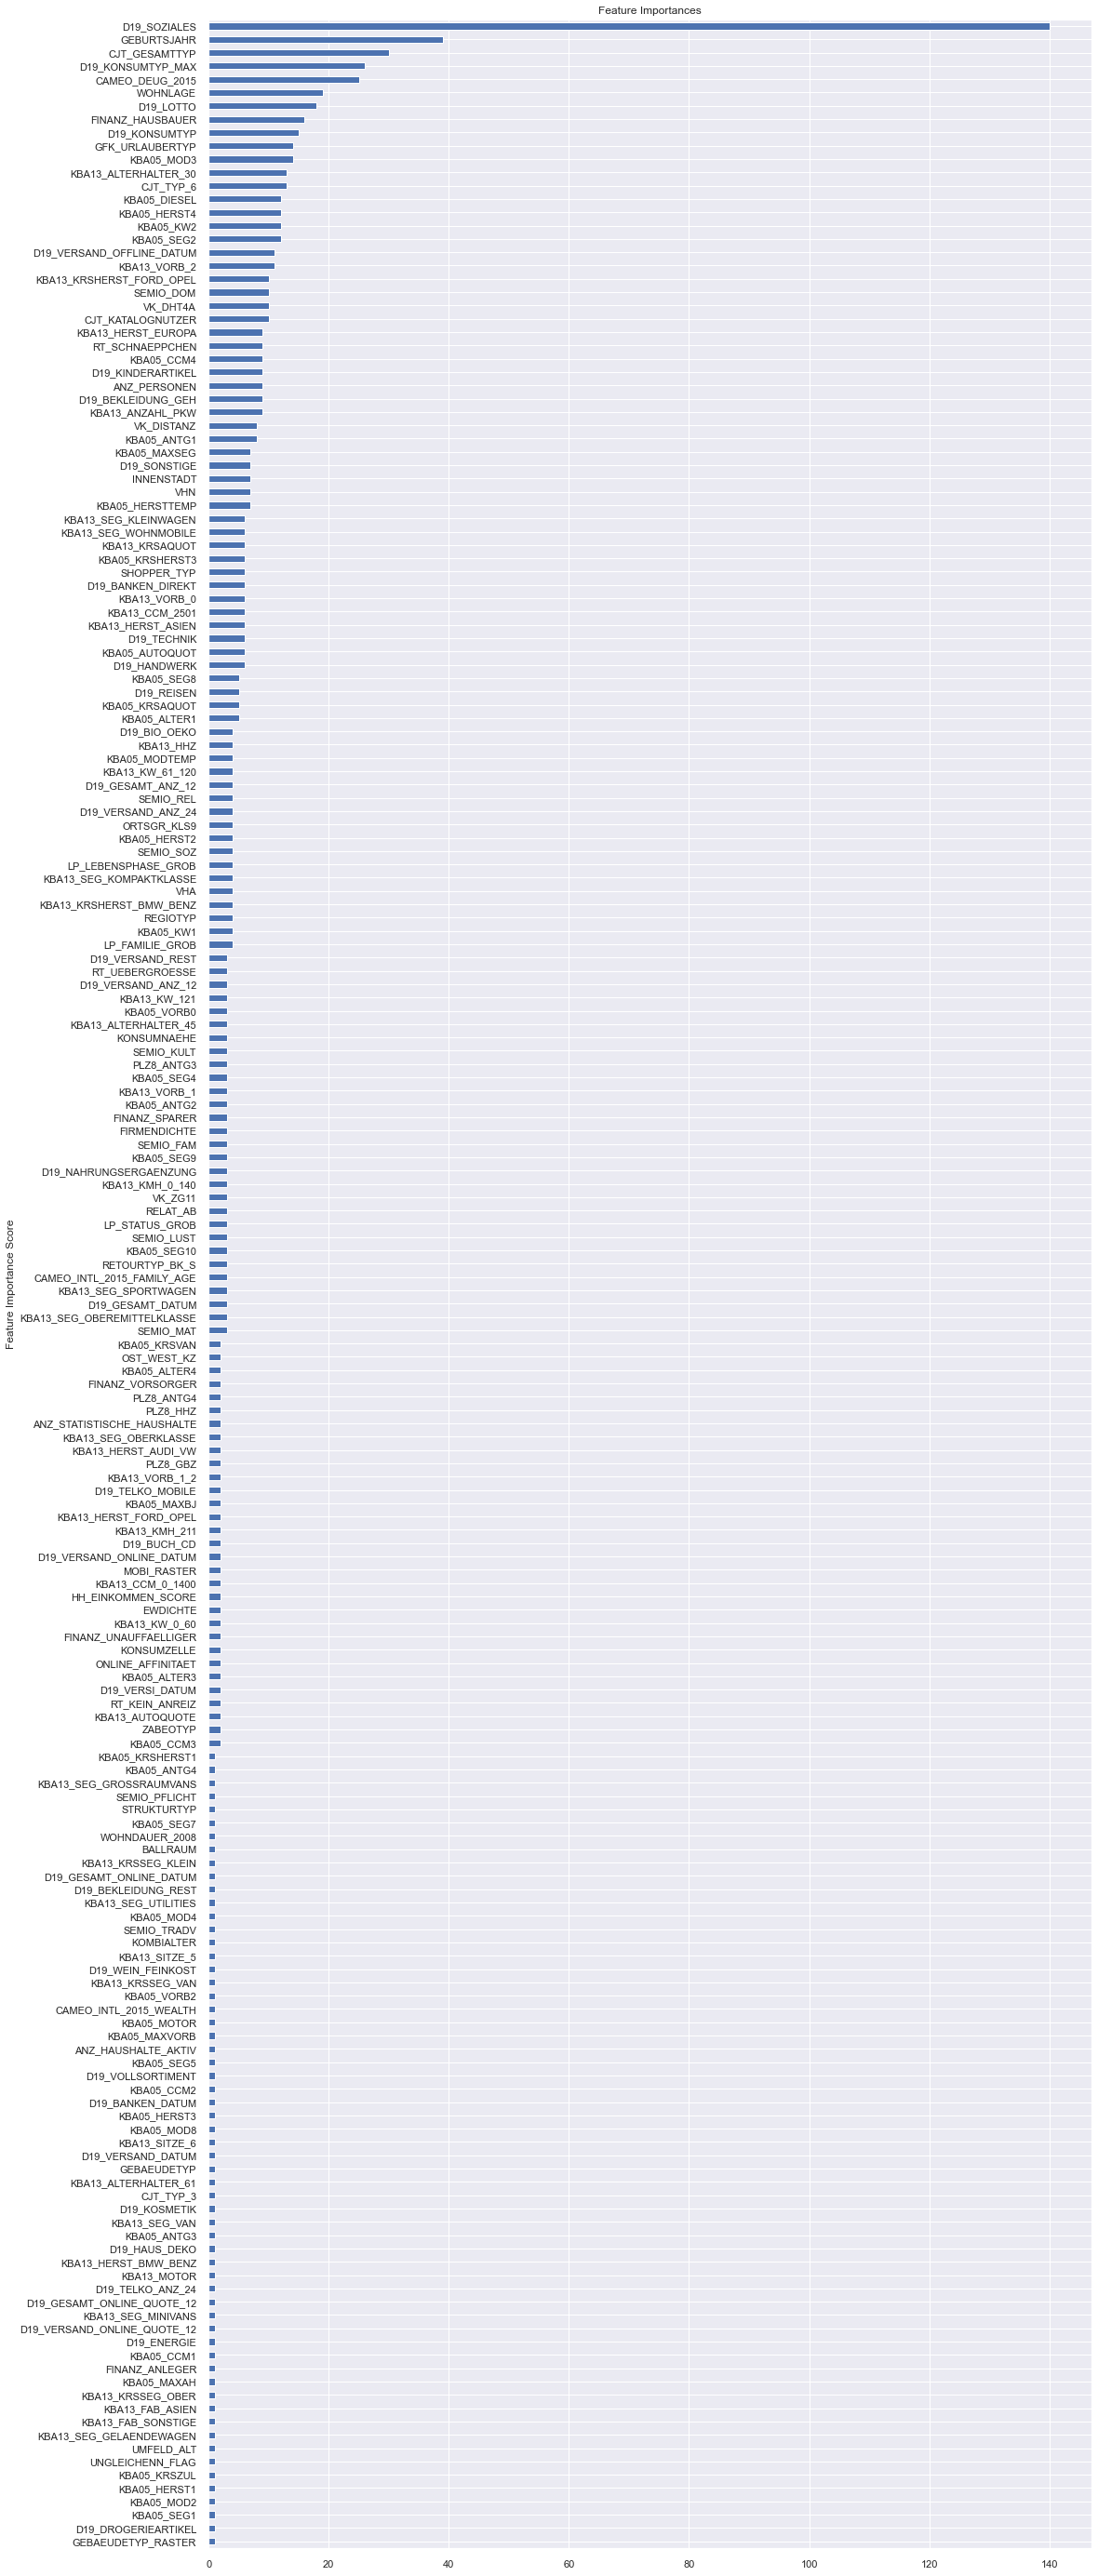

In [330]:
%%time
xgb7 = XGBClassifier( 
    learning_rate=0.038, 
    n_estimators=5000, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    reg_alpha=reg_alpha,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
mf=xgb_modelfit(xgb7, train_df, predictor_column_names, cv_folds=5, generate_plot=True, figsize=(17, 50))

In [331]:
mf.shape

(325, 4)

In [332]:
learning_rate = 0.038
n_estimators = mf.shape[0]

In [333]:
%%time
xgb8 = XGBClassifier( 
    learning_rate=learning_rate, 
    n_estimators=n_estimators, 
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    reg_alpha=reg_alpha,
    objective= 'binary:logistic', 
    nthread=n_jobs, 
    scale_pos_weight=scale_pos_weight, 
    seed=27,
    use_label_encoder=False,
    verbosity=1
)
gsearch8 = GridSearchCV(
    estimator=xgb8, 
    param_grid={}, 
    scoring='roc_auc',
    n_jobs=n_jobs,
    verbose=2, 
    cv=5
)
gsearch8.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   37.2s finished


[01:48:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 49.1 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.038, max_delta_step=None,
                                     max_depth=2, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=325, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=300, reg_lambda=None,
                                     scale_pos_weight=79.67840375586854,
                                     seed=27, subsampl

In [334]:
gsearch8.best_estimator_, gsearch8.best_params_, gsearch8.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.9, gamma=0.0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.038, max_delta_step=0, max_depth=2,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=325, n_jobs=4, nthread=4, num_parallel_tree=1,
               random_state=27, reg_alpha=300, reg_lambda=1,
               scale_pos_weight=79.67840375586854, seed=27, subsample=0.7,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=1),
 {},
 0.7704952923395858)

In [335]:
save_model(gsearch8.best_estimator_, estimator_filenames['xgb'])

In [336]:
%%time

model = load_model(estimator_filenames['xgb'])
roc_scores['xgb'] = (
    roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
    roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
)
print(model)
print('Classification-Report on training data:\n', classification_report(y_train, model.predict(X_train)))
print('Confusion-Matrix on training data:\n',confusion_matrix(y_train, model.predict(X_train)))
print('ROC score on training data:', roc_scores['xgb'][0])
print('Classification-Report on validation data:\n', classification_report(y_val, model.predict(X_val)))
print('Confusion-Matrix on validation data:\n',confusion_matrix(y_val, model.predict(X_val)))
print('ROC score on validation data:', roc_scores['xgb'][1])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.038, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=325, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=300, reg_lambda=1,
              scale_pos_weight=79.67840375586854, seed=27, subsample=0.7,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)
Classification-Report on training data:
               precision    recall  f1-score   support

           0       1.00      0.73      0.84     33943
           1       0.03      0.74      0.06       426

    accuracy                           0.73     34369
   macro avg       0.51      0.74      0.45     34369
weighted avg    

In [337]:
model = load_model(estimator_filenames['xgb'])
kaggle = pd.DataFrame(index=mailout_test.index, data=model.predict_proba(mailout_test)[:,1], columns=['RESPONSE'])
kaggle.reset_index().to_csv(kaggle_filenames['xgb'], index=False)

## Tune MLP
Neural nets perfoem better on scaled data
* Pipeline idea taken from https://towardsdatascience.com/preventing-data-leakage-in-your-machine-learning-model-9ae54b3cd1fb

In [338]:
%%time

mlp1 = MLPClassifier(
    random_state=42, 
    activation='logistic', 
    solver='adam', 
    learning_rate='adaptive',
    verbose=2
)
mlp_pipe1 = Pipeline(
    steps=[
        ('scale', MinMaxScaler()),
        ('mlp', mlp1)
    ]
)

gs_mlp1 = GridSearchCV(
    estimator = mlp_pipe1, 
    param_grid = {
        'mlp__hidden_layer_sizes': [(272,272,272), (272,272,272,272,272)]
    }, 
    scoring = "roc_auc", 
    cv=5, 
    n_jobs=4, 
    verbose=2
)
gs_mlp1.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 12.5min finished


Iteration 1, loss = 0.08305427
Iteration 2, loss = 0.06696469
Iteration 3, loss = 0.06697888
Iteration 4, loss = 0.06706537
Iteration 5, loss = 0.06697824
Iteration 6, loss = 0.06702528
Iteration 7, loss = 0.06724736
Iteration 8, loss = 0.06716165
Iteration 9, loss = 0.06698864
Iteration 10, loss = 0.06718451
Iteration 11, loss = 0.06706386
Iteration 12, loss = 0.06702467
Iteration 13, loss = 0.06702004
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Wall time: 13min 11s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('mlp',
                                        MLPClassifier(activation='logistic',
                                                      learning_rate='adaptive',
                                                      random_state=42,
                                                      verbose=2))]),
             n_jobs=4,
             param_grid={'mlp__hidden_layer_sizes': [(272, 272, 272),
                                                     (272, 272, 272, 272,
                                                      272)]},
             scoring='roc_auc', verbose=2)

In [339]:
gs_mlp1.best_estimator_, gs_mlp1.best_params_, gs_mlp1.best_score_

(Pipeline(steps=[('scale', MinMaxScaler()),
                 ('mlp',
                  MLPClassifier(activation='logistic',
                                hidden_layer_sizes=(272, 272, 272, 272, 272),
                                learning_rate='adaptive', random_state=42,
                                verbose=2))]),
 {'mlp__hidden_layer_sizes': (272, 272, 272, 272, 272)},
 0.592939718690832)

In [340]:
save_model(gs_mlp1.best_estimator_, estimator_filenames['mlp'])
print(gs_mlp1.best_estimator_)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('mlp',
                 MLPClassifier(activation='logistic',
                               hidden_layer_sizes=(272, 272, 272, 272, 272),
                               learning_rate='adaptive', random_state=42,
                               verbose=2))])


In [123]:
#del gs_mlp1, mlp1

In [341]:
%%time

model = load_model(estimator_filenames['mlp'])
roc_scores['mlp'] = (
    roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
    roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
)
print(model)
print('Classification-Report on training data:\n', classification_report(y_train, model.predict(X_train)))
print('Confusion-Matrix on training data:\n',confusion_matrix(y_train, model.predict(X_train)))
print('ROC score on training data:', roc_scores['mlp'][0])
print('Classification-Report on validation data:\n', classification_report(y_val, model.predict(X_val)))
print('Confusion-Matrix on validation data:\n',confusion_matrix(y_val, model.predict(X_val)))
print('ROC score on validation data:', roc_scores['mlp'][1])

Pipeline(steps=[('scale', MinMaxScaler()),
                ('mlp',
                 MLPClassifier(activation='logistic',
                               hidden_layer_sizes=(272, 272, 272, 272, 272),
                               learning_rate='adaptive', random_state=42,
                               verbose=2))])


C:\Users\thorssc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification-Report on training data:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     33943
           1       0.00      0.00      0.00       426

    accuracy                           0.99     34369
   macro avg       0.49      0.50      0.50     34369
weighted avg       0.98      0.99      0.98     34369

Confusion-Matrix on training data:
 [[33943     0]
 [  426     0]]
ROC score on training data: 0.6488927377421884


C:\Users\thorssc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification-Report on validation data:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      8487
           1       0.00      0.00      0.00       106

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593

Confusion-Matrix on validation data:
 [[8487    0]
 [ 106    0]]
ROC score on validation data: 0.6203244251474509
Wall time: 3.25 s


## Tune Logistic Regression

In [342]:
%%time
lr1 = LogisticRegression(random_state=42, penalty='l2')
lr_pipe1 = Pipeline(
    steps=[
        ('scale', MinMaxScaler()),
        ('lr', lr1)
    ]
)
gs_logisticregression1 = GridSearchCV(
    estimator = lr_pipe1, 
    param_grid = {
        'lr__max_iter': [100, 1000, 10000, 20000],
        'lr__C': np.logspace(0, 4, 10)[:6]
    }, 
    scoring = "roc_auc", 
    cv = 5, n_jobs = 4, verbose=2
)
gs_logisticregression1.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   56.8s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  5.4min finished


Wall time: 5min 29s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=4,
             param_grid={'lr__C': array([  1.        ,   2.7825594 ,   7.74263683,  21.5443469 ,
        59.94842503, 166.81005372]),
                         'lr__max_iter': [100, 1000, 10000, 20000]},
             scoring='roc_auc', verbose=2)

In [343]:
gs_logisticregression1.best_estimator_, gs_logisticregression1.best_params_, gs_logisticregression1.best_score_

(Pipeline(steps=[('scale', MinMaxScaler()),
                 ('lr', LogisticRegression(max_iter=1000, random_state=42))]),
 {'lr__C': 1.0, 'lr__max_iter': 1000},
 0.6622666298216661)

In [344]:
save_model(gs_logisticregression1.best_estimator_, estimator_filenames['logreg'])
print(gs_logisticregression1.best_estimator_)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])


In [129]:
#del gs_logisticregression1, lr1

In [345]:
%%time

model = load_model(estimator_filenames['logreg'])
roc_scores['logreg'] = (
    roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
    roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
)
print(model)
print('Classification-Report on training data:\n', classification_report(y_train, model.predict(X_train)))
print('Confusion-Matrix on training data:\n',confusion_matrix(y_train, model.predict(X_train)))
print('ROC score on training data:', roc_scores['logreg'][0])
print('Classification-Report on validation data:\n', classification_report(y_val, model.predict(X_val)))
print('Confusion-Matrix on validation data:\n',confusion_matrix(y_val, model.predict(X_val)))
print('ROC score on validation data:', roc_scores['logreg'][1])

Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])
Classification-Report on training data:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     33943
           1       0.00      0.00      0.00       426

    accuracy                           0.99     34369
   macro avg       0.49      0.50      0.50     34369
weighted avg       0.98      0.99      0.98     34369



C:\Users\thorssc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion-Matrix on training data:
 [[33943     0]
 [  426     0]]
ROC score on training data: 0.7923429073789681
Classification-Report on validation data:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      8487
           1       0.00      0.00      0.00       106

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593

Confusion-Matrix on validation data:
 [[8487    0]
 [ 106    0]]
ROC score on validation data: 0.7129133124801306
Wall time: 615 ms


C:\Users\thorssc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [353]:
roc_stat = {
    'Name': [],
    'ROC-AUC Train': [],
    'ROC-AUC Validation': []
}
for k, v in roc_scores.items():
    roc_stat['Name'].append(model_names[k])
    roc_stat['ROC-AUC Train'].append(roc_scores[k][0])
    roc_stat['ROC-AUC Validation'].append(roc_scores[k][1])
pd.DataFrame(roc_stat).set_index('Name')

ROC-AUC Train  ROC-AUC Validation
Name                                                        
Random Forest (Benchmark)       0.957071            0.783675
Extra Trees                     0.965571            0.789718
XGBoost                         0.839701            0.777371
Multi Layer Perceptron          0.648893            0.620324
Logistic Regression             0.792343            0.712913

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

## Generate Kaggle Submissions

In [347]:
%%time

model = load_model(estimator_filenames['benchmark'])
kaggle = pd.DataFrame(index=mailout_test.index, data=model.predict_proba(mailout_test)[:,1], columns=['RESPONSE'])
kaggle.reset_index().to_csv(kaggle_filenames['benchmark'], index=False)

model = load_model(estimator_filenames['extra'])
kaggle = pd.DataFrame(index=mailout_test.index, data=model.predict_proba(mailout_test)[:,1], columns=['RESPONSE'])
kaggle.reset_index().to_csv(kaggle_filenames['extra'], index=False)

model = load_model(estimator_filenames['xgb'])
kaggle = pd.DataFrame(index=mailout_test.index, data=model.predict_proba(mailout_test)[:,1], columns=['RESPONSE'])
kaggle.reset_index().to_csv(kaggle_filenames['xgb'], index=False)

model = load_model(estimator_filenames['mlp'])
kaggle = pd.DataFrame(index=mailout_test.index, data=model.predict_proba(mailout_test)[:,1], columns=['RESPONSE'])
kaggle.reset_index().to_csv(kaggle_filenames['mlp'], index=False)

model = load_model(estimator_filenames['logreg'])
kaggle = pd.DataFrame(index=mailout_test.index, data=model.predict_proba(mailout_test)[:,1], columns=['RESPONSE'])
kaggle.reset_index().to_csv(kaggle_filenames['logreg'], index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.0s finished


Wall time: 3.92 s


**Benchmark**
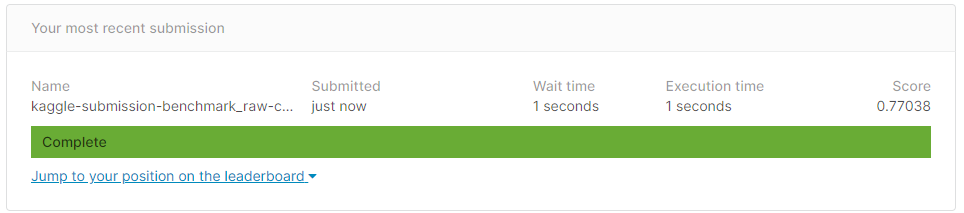

**Extra Trees**
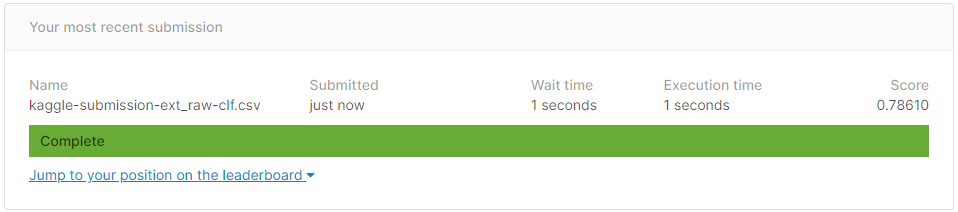

**XGBoost**
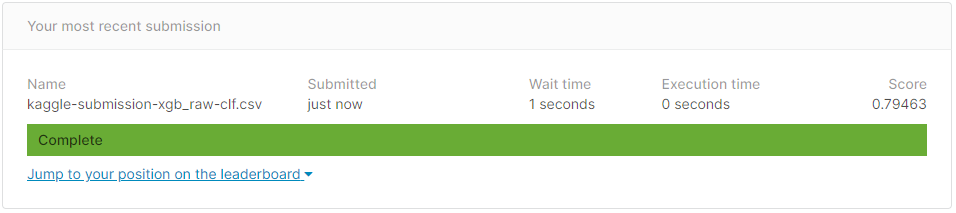

**MLP**
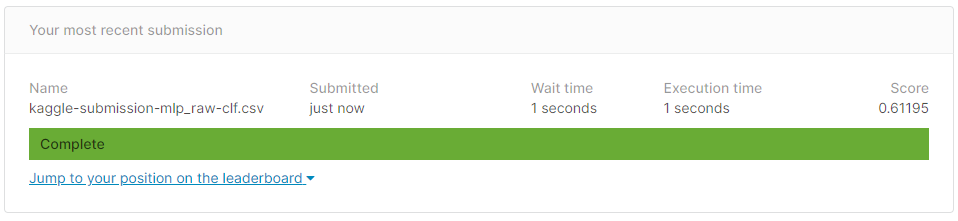

**Logistic Regression**
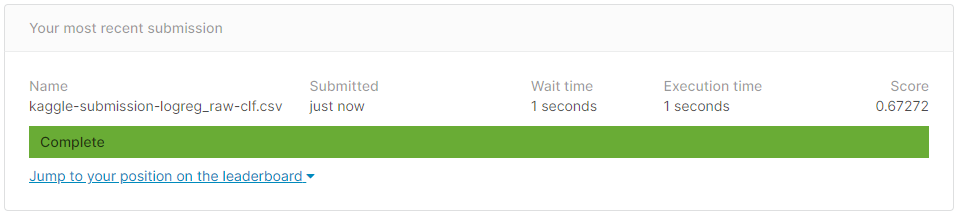

In [357]:
kaggle_score = {}
kaggle_score['benchmark']= 0.77038
kaggle_score['extra'] = 0.78610
kaggle_score['xgb'] = 0.79463
kaggle_score['mlp'] = 0.61195
kaggle_score['logreg'] = 0.67272
roc_stat = {
    'Name': [],
    'AUROC Train': [],
    'AUROC Validation': [],
    'KAGGLE submission': [],
}
for k, v in roc_scores.items():
    roc_stat['Name'].append(model_names[k])
    roc_stat['AUROC Train'].append(roc_scores[k][0])
    roc_stat['AUROC Validation'].append(roc_scores[k][1])
    roc_stat['KAGGLE submission'].append(kaggle_score[k])
pd.DataFrame(roc_stat).set_index('Name')

AUROC Train  AUROC Validation  KAGGLE submission
Name                                                                       
Random Forest (Benchmark)     0.957071          0.783675            0.77038
Extra Trees                   0.965571          0.789718            0.78610
XGBoost                       0.839701          0.777371            0.79463
Multi Layer Perceptron        0.648893          0.620324            0.61195
Logistic Regression           0.792343          0.712913            0.67272